In [1]:
# !pip install sciann fteikpy pyDOE -q 

In [2]:
import time

In [3]:
import numpy as np
import sciann as sn 
import matplotlib.pyplot as plt

%matplotlib inline

---------------------- SCIANN 0.6.7.6 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.8.3 
Python Version: 3.8.13 (default, Mar 28 2022, 11:38:47) 
[GCC 7.5.0] 



In [4]:
import tensorflow as tf
tf.test.gpu_device_name()

2022-10-16 08:46:27.988193: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-16 08:46:28.618960: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-16 08:46:28.626296: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-16 08:46:28.626902: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

'/device:GPU:0'

# Testing different velocity models 

In [5]:
from fteikpy import Eikonal2D

class EikonalSolver:
    def __init__(self, xd = [-1.0, 1.0],
                       yd = [-1.0, 1.0],
                       vel = np.ones((10, 10)),
                       source = [0.0, 0.0]):
        self.origin = (xd[0], yd[0])
        Nx, Ny = [n - 1 for n in vel.shape]
        dx, dy = (xd[1]-xd[0])/(Nx), (yd[1]-yd[0])/(Ny)
        vs = (vel[:-1, :-1] + vel[1:, 1:])/2.0
        eik = Eikonal2D(vs, gridsize=(dx, dy))
        src = (source[0]-xd[0], source[1]-yd[0])
        self.dx = (dx, dy)
        self.eik = eik.solve(src)
        
    def __call__(self, xs=0., ys=0.):
        data = np.hstack([(xs - self.origin[0]).reshape(-1, 1), 
                          (ys - self.origin[1]).reshape(-1, 1)])
        return self.eik(data).reshape(xs.shape)
    
    @property
    def grid(self):
        return self.eik.grid
    
    @property
    def grad(self):
        Tx, Ty = np.gradient(self.eik.grid)
        return (Tx/self.dx[0], Ty/self.dx[1])
  

[7.064680661900527, 0.4345625656332897, 7.099443862859816, 6.724626144282214]


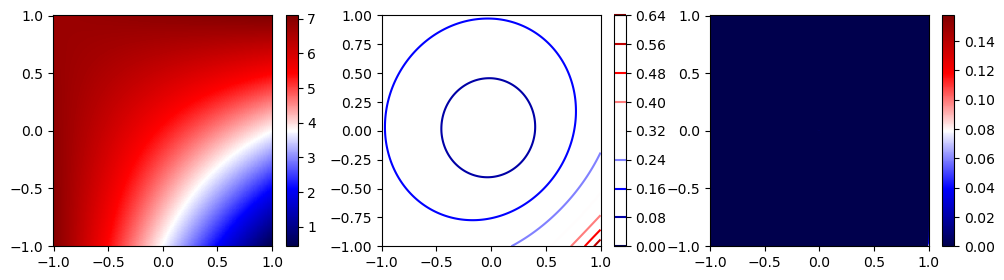

[4.582617326392684, 5.113854138383645, 4.590828122105383, 6.317912211652327]


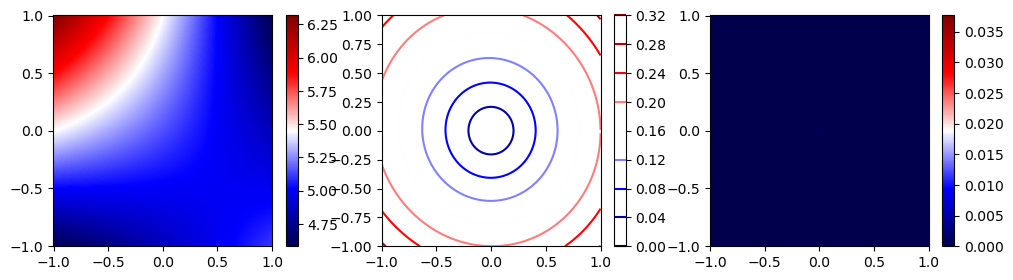

[2.6048190265140976, 6.100740594510594, 6.233248738377128, 3.4219207552888586]


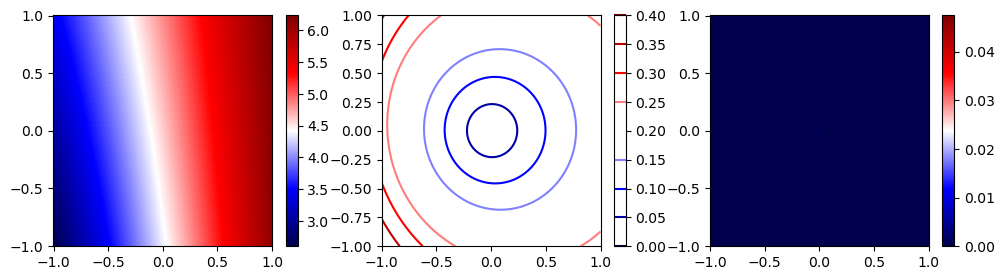

In [6]:
grid_1d = np.linspace(-1, 1, 501)
x, y  = np.meshgrid(grid_1d, grid_1d)

shapes = [
    lambda x, y: (1-x)*(1-y)/4,
    lambda x, y: (1+x)*(1-y)/4,
    lambda x, y: (1+x)*(1+y)/4,
    lambda x, y: (1-x)*(1+y)/4,
]
for i in range(3):
    corner_velocities = list(np.random.uniform(0.2, 8, (4,)))
    print(corner_velocities)
    v = sum([vi*ni(x, y) for vi, ni in zip(corner_velocities, shapes)])
    
    eik = EikonalSolver(vel=v)
    t = eik.grid 
    gt = eik.grad 
    res = abs(gt[0]**2 + gt[1]**2 - 1/v**2)

    fig, ax = plt.subplots(1,3,figsize=(12,3))
    plt.colorbar(
        ax[0].pcolor(x, y, v, cmap='seismic'), ax=ax[0]
    )
    plt.colorbar(
        ax[1].contour(x, y, t, cmap='seismic'), ax=ax[1]
    )
    plt.colorbar(
        ax[2].pcolor(x, y, res, cmap='seismic'), ax=ax[2]
    )
    plt.show()

In [7]:
from pyDOE import *

def lhs_uniform(d, n, bb = None):
    samples = lhs(d, n)
    if not bb:
        bb = [[0, 1] for i in range(d)]
    data = []
    for i, bb_i, in zip(range(d), bb):
        data.append(
            bb_i[0] + (bb_i[1]-bb_i[0]) * samples[:, i]
        )
    return data if len(data)>1 else data[0]

In [8]:
RECEIVER_SIZE = 20
SENSOR_SIZE = 100
SOURCE_RADI = 0.
VMIN = 0.2
VMAX = 8.0

In [9]:
from tensorflow.keras.utils import Sequence 


class DataGenerator(Sequence):
    def __init__(self, sample_size = 100, 
                       batch_size = dict(data=1000, domain=1000, bc=100),
                       sensor_size = 10,
                       recevier_size = 10,
                       source_radius = 0.1,
                       shuffle = True,
                       seed=1234):
        # generate data
        self._radius = source_radius
        self._sample_size = sample_size
        self._batch_size = batch_size
        self._sensor_size = sensor_size
        sensor_size_1d = int(np.sqrt(self._sensor_size) + 0.001)
        grid_1d_s = np.linspace(-1, 1, sensor_size_1d + 2)[1:-1]
        self._sensor = [gi.flatten() for gi in np.meshgrid(grid_1d_s, grid_1d_s)]
        self._recevier_size = recevier_size
        self._receiver = [np.linspace(-1, 1, recevier_size+2)[1:-1], 
                          np.ones(recevier_size)]
        self._shuffle = shuffle
        self._vmin = VMIN
        self._rmin = np.exp(np.log(VMIN/self._vmin) / 100)
        self._vmax = VMAX
        self._rmax = np.exp(np.log(VMAX/self._vmax) / 100)
        self._epoch = 1
        self._time = time.time()
        self._set_data()
        
    @property
    def batch_size(self):
        return self._batch_size

    def __len__(self):
        return self._sample_size

    def __getitem__(self, index):
        idx = self._sample_ids[index]
        return self.inputs[idx], self.targets[idx], self.sample_weights[idx]

    def on_epoch_end(self):
        if self._epoch % 100 == 0:
        #     self._vmin = max(VMIN, self._vmin*self._rmin)
        #     self._vmax = min(VMAX, self._vmax*self._rmax)
        #     self._set_data()
            print(f"{self._epoch} - {self._time - time.time()}s - re-sampling with vmin={self._vmin}, vmax={self._vmax}")
        if self._shuffle:
            np.random.shuffle(self._sample_ids)
        self._epoch += 1

    def _set_data(self):
        num_sample, batch_size = self._sample_size, self._batch_size
        inputs, targets, sample_weights = [], [], []
        for i in range(num_sample):
            x_source, y_source = list(np.random.uniform(-0.9, 0.9, 2))
            corner_velocities = list(np.random.uniform(self._vmin, self._vmax, (4,)))
            inputs_i, targets_i, sample_weights_i = self.__generate_batch_data(x_source, y_source, corner_velocities, batch_size)
            inputs.append(inputs_i)
            targets.append(targets_i)
            sample_weights.append(sample_weights_i)
        # concat data
        self.inputs = inputs
        self.targets = targets
        self.sample_weights = sample_weights
        self._sample_ids = np.arange(num_sample)

    def __generate_batch_data(self, x_source, y_source, corner_velocities, batch_size):
        counter = 0
        
        # eikonal (travel-time) solution
        grid_1d = np.linspace(-1, 1, 101)
        x_grid, y_grid = np.meshgrid(grid_1d, grid_1d)
        v_grid = self.interpolate_corner_velocities(corner_velocities, x_grid, y_grid)
        eik2d = EikonalSolver(vel=v_grid, source=[x_source, y_source])
        
        # sample data
        ids_data = np.random.choice(x_grid.size, batch_size['data'], replace=False)
        x_data, y_data = x_grid.flatten()[ids_data], y_grid.flatten()[ids_data]
        target_data = eik2d.grid.flatten()[ids_data]
        ids_data = np.arange(batch_size['data']) + counter
        counter += ids_data.size

        size_sample = counter
        
        # trunk inputs
        x_trunk = np.hstack([x_data]).reshape(-1,1)
        y_trunk = np.hstack([y_data]).reshape(-1,1)
        
        # - BRANCH -
        # velocity-branch inputs
        x_sensor, y_sensor = self._sensor
        v_sensor = self.interpolate_corner_velocities(corner_velocities, x_sensor, y_sensor)
        v_branch = np.tile(v_sensor, (size_sample, 1))
        
        # recevier-branch inputs
        x_receiver, y_receiver = self._receiver
        t_receiver = eik2d(x_receiver, y_receiver)
        t_branch = np.tile(t_receiver, (size_sample, 1))

        # inputs
        inputs = [x_trunk, y_trunk, v_branch, t_branch]
        targets, sample_weights = [], []
        for idx, tg in zip([ids_data],
                           [target_data]):
            wi = np.zeros(size_sample)
            wi[idx] = size_sample / idx.size
            sample_weights.append(wi)
            ti = np.zeros((size_sample, ))
            if isinstance(tg, np.ndarray):
                ti[idx] = tg
            targets.append(ti.reshape(-1,1))
        
        return inputs, targets, sample_weights
    
    
    def generate_test_data(self, Xs, Ys, Vs, Nx=100, Ny=100, sensor_size=10):
        counter = 0
        radi = self._radius
        
        # eikonal solution
        x_grid, y_grid = np.meshgrid(np.linspace(-1,1,Nx), np.linspace(-1,1,Ny))
        v_grid = self.interpolate_corner_velocities(Vs, x_grid, y_grid)
        eik2d = EikonalSolver(vel=v_grid, source=[Xs, Ys])
        t_grid = eik2d.grid
        
        # sample domain
        x_trunk, y_trunk = x_grid.reshape(-1,1), y_grid.reshape(-1,1)
        v_trunk = v_grid.reshape(-1,1)
        target = t_grid.reshape(-1,1)
        size_sample = Nx*Ny
        
        # velocity-branch inputs
        x_sensor, y_sensor = self._sensor
        v_sensor = self.interpolate_corner_velocities(Vs, x_sensor, y_sensor)
        v_branch = np.tile(v_sensor, (size_sample, 1))
        
        # recevier-branch inputs
        x_receiver, y_receiver = self._receiver
        t_receiver = eik2d(x_receiver, y_receiver)
        t_branch = np.tile(t_receiver, (size_sample, 1))

        # inputs
        inputs = [x_trunk, y_trunk, v_branch, t_branch]
        
        return inputs, v_trunk, target
    
    def interpolate_corner_velocities(self, vs, x, y):
        shapes = [lambda x, y: (1-x)*(1-y)/4, # bottom-left
                  lambda x, y: (1+x)*(1-y)/4, # bottom-right
                  lambda x, y: (1-x)*(1+y)/4, # top-left
                  lambda x, y: (1+x)*(1+y)/4] # top-right
        return sum([vi*si(x, y) for vi, si in zip(vs, shapes)])


In [10]:
sn.reset_session()
sn.set_random_seed(1234)

In [11]:
# Define the model
class PI_DeepONet:
    def __init__(self, sensor_size=20, 
                       receiver_size=20,
                       embedding_size=20,
                       trunk_layers=7*[20],
                       sensor_branch_layers=7*[20],
                       receiver_branch_layers=7*[20], 
                       actf='tanh'):
        
        # velocity (sensor) branch net
        self.branch_inputs = [sn.Variable('vb', units=sensor_size)]
        self.branch_embedding = sn.Field('branch', units=embedding_size)
        self.branch = sn.Functional(self.branch_embedding, self.branch_inputs, sensor_branch_layers, actf, actf)
        
        # receiver branch net
        self.r_branch_inputs = [sn.Variable('rb', units=receiver_size)]
        self.r_branch_embedding = sn.Field('r_branch', units=embedding_size)
        self.r_branch = sn.Functional(self.r_branch_embedding, self.r_branch_inputs, receiver_branch_layers, actf, actf)
        
        
        # Network initialization and evaluation functions
        self.trunk_inputs = [sn.Variable('xt'), sn.Variable('yt')]
        
        self.trunk_embedding = sn.Field('trunk-0', units=embedding_size)
        self.trunk = sn.Functional(self.trunk_embedding, self.trunk_inputs, output_activation=actf)
        
        for i in range(4):
            hidden_inputs = [self.trunk * self.branch, 
                             self.trunk + self.branch, 
                             self.trunk * self.r_branch,
                             self.trunk + self.r_branch]
            self.trunk_embedding = sn.Field('trunk-{}'.format(i+1), units=embedding_size)
            self.trunk = sn.Functional(self.trunk_embedding, hidden_inputs, output_activation=actf)
        
        
        hidden_inputs = [self.trunk * self.branch, 
                         self.trunk + self.branch, 
                         self.trunk * self.r_branch,
                         self.trunk + self.r_branch]
        
        self.output = sn.Functional('u', hidden_inputs)
        
        du_dx = sn.diff(self.output, self.trunk_inputs[0])
        du_dy = sn.diff(self.output, self.trunk_inputs[1])
        eikonal = sn.rename(du_dx**2 + du_dy**2, 'eikonal')
        data = sn.rename(self.output*1.0, 'data')
        
        #lipschitz reg
        du_dvbranch = sn.diff(self.output, self.branch_inputs[0])
        du_dtbranch = sn.diff(self.output, self.r_branch_inputs[0])
        
        self.losses = [data] #, du_dvbranch, du_dtbranch]
        
        self.model = sn.SciModel(self.trunk_inputs + self.branch_inputs + self.r_branch_inputs,
                                 self.losses,
                                 optimizer='adam')
        
        self.model_bfgs = sn.SciModel(self.trunk_inputs + self.branch_inputs + self.r_branch_inputs,
                                      self.losses,
                                      optimizer='scipy-l-bfgs-b')
    
        
    def eval(self, inputs):
        return self.model(inputs)

    def eval_u(self, inputs):
        return self.output.eval(self.model, inputs)
    
    def train(self, data_generator, epochs=200, verbose=1):
        batch_size = data_generator.batch_size
        learning_rate = dict(scheduler="exponential_decay", 
                             initial_learning_rate=4e-4,
                             final_learning_rate=1e-5,
                             delay_epochs=1000,
                             decay_epochs=10000)
        learning_rate = ([0,       500, 1500, 2000,    3000,   5000, 10000], 
                         [0.5e-4, 1e-4, 1e-4, 2e-4, 0.75e-4, 0.5e-4,  1e-5])
        self.history = self.model.train(
            data_generator,
            epochs=epochs, 
            batch_size=batch_size, 
            verbose=verbose, 
            learning_rate=learning_rate,
            reduce_lr_after=100,
            # target_weights=[1., 0.01, 0.01]
            save_weights={"path": "EnDeepONet_SmoothVelocity/weights", "freq": 100}
        )
        return self.history
    
    def train_lbfgs(self, data_generator, epochs=200, verbose=1):
        batch_size = data_generator.batch_size
        self.history_bfgs = self.model_bfgs.train(
            data_generator,
            epochs=epochs,
            batch_size=batch_size,
            verbose=verbose,
            learning_rate=0.001
        )
        return self.history_bfgs
    
    def plot_loss(self):
        loss = self.history.history["loss"]
        plt.semilogy(np.array(loss) / loss[0], label="total_loss")
        plt.legend()
        plt.show()

In [12]:
dg = DataGenerator(
    sample_size=200,
    batch_size={'data': 2000, 'domain': 1000, 'bc':50},
    sensor_size=SENSOR_SIZE,
    recevier_size=RECEIVER_SIZE,
    source_radius=SOURCE_RADI
)

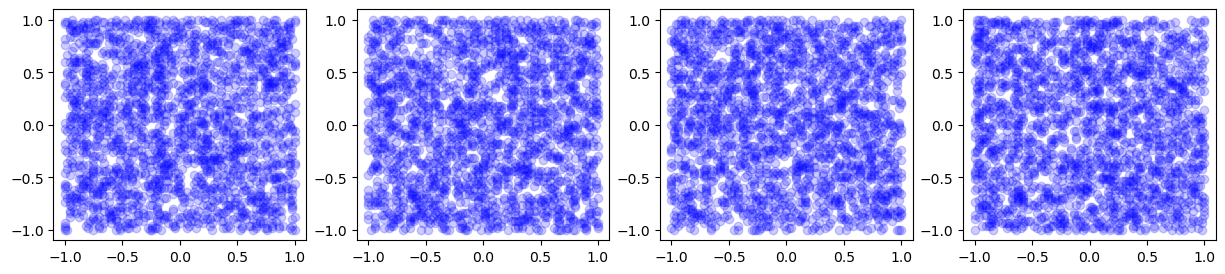

In [13]:
from itertools import cycle

n_plot = 4
fig, ax = plt.subplots(1, n_plot, figsize=(15, 3))
for i in range(n_plot):
    cycol = cycle('brycmg')
    inputs, targets, weights = dg[np.random.choice(len(dg))]
    for wi in weights:
        x_trunk, y_trunk, v_branch, t_branch = inputs
        idx = wi > 0
        ax[i].scatter(x_trunk[idx], y_trunk[idx], color=next(cycol), alpha=0.2)

plt.show()

In [14]:
DON = PI_DeepONet(
    sensor_size=SENSOR_SIZE,
    receiver_size=RECEIVER_SIZE,
    embedding_size=100,
    sensor_branch_layers=[100, 100],
    receiver_branch_layers=[100, 100],
    trunk_layers=[20, 50, 100, 100],
    actf='tanh'
)

In [15]:
DON.train(dg, epochs=10000, verbose=0)
# [x.shape for x in dg[0][0]]

2022-10-16 08:46:44.043246: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-16 08:46:44.043941: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-16 08:46:44.044509: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-16 08:46:44.045435: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-16 08:46:44.046068: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

100 - -98.71865844726562s - re-sampling with vmin=0.2, vmax=8.0
200 - -192.40746021270752s - re-sampling with vmin=0.2, vmax=8.0
300 - -286.03696942329407s - re-sampling with vmin=0.2, vmax=8.0
400 - -379.6593029499054s - re-sampling with vmin=0.2, vmax=8.0
500 - -473.19195914268494s - re-sampling with vmin=0.2, vmax=8.0
600 - -566.6413040161133s - re-sampling with vmin=0.2, vmax=8.0
700 - -660.2160685062408s - re-sampling with vmin=0.2, vmax=8.0
800 - -753.8623614311218s - re-sampling with vmin=0.2, vmax=8.0
900 - -847.489156961441s - re-sampling with vmin=0.2, vmax=8.0
1000 - -941.1071832180023s - re-sampling with vmin=0.2, vmax=8.0
1100 - -1034.6100058555603s - re-sampling with vmin=0.2, vmax=8.0
1200 - -1128.2097358703613s - re-sampling with vmin=0.2, vmax=8.0
1300 - -1221.8460538387299s - re-sampling with vmin=0.2, vmax=8.0
1400 - -1315.4365820884705s - re-sampling with vmin=0.2, vmax=8.0
1500 - -1409.0591342449188s - re-sampling with vmin=0.2, vmax=8.0
1600 - -1502.7162902355194s

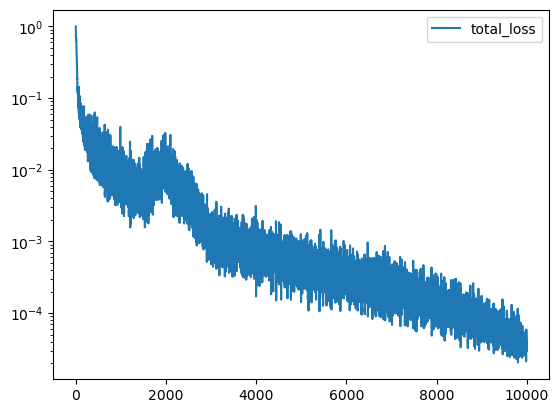

In [16]:
DON.plot_loss()

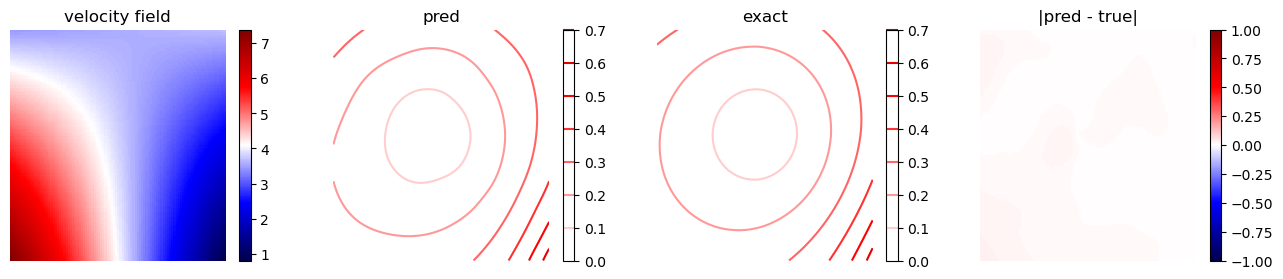

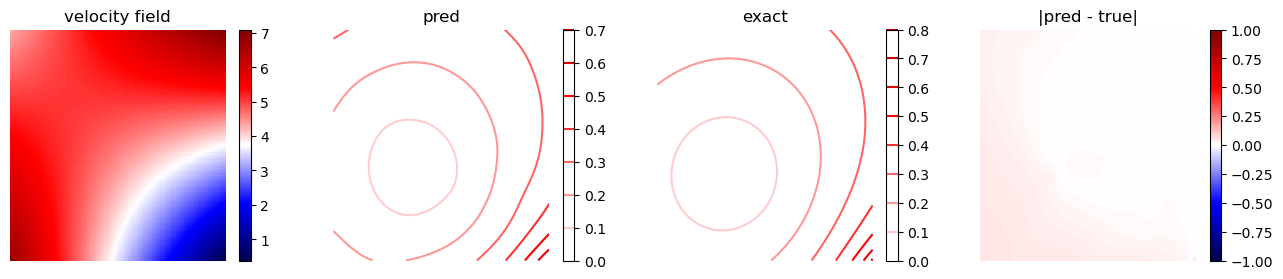

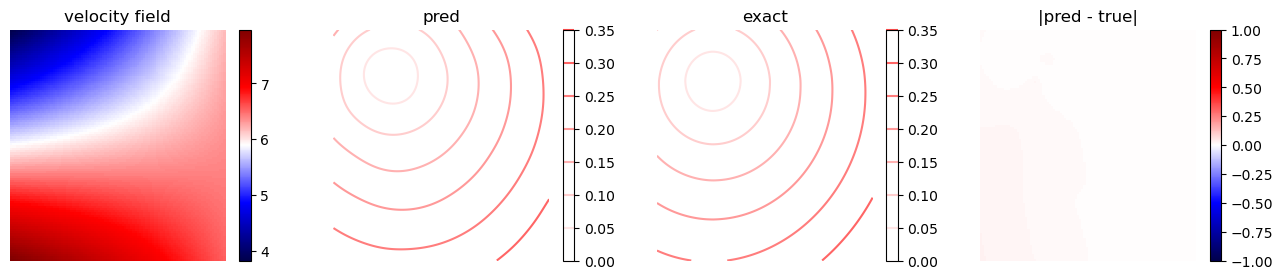

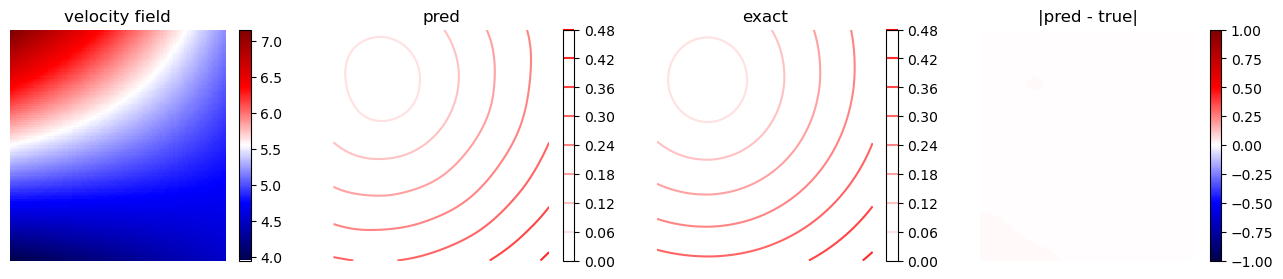

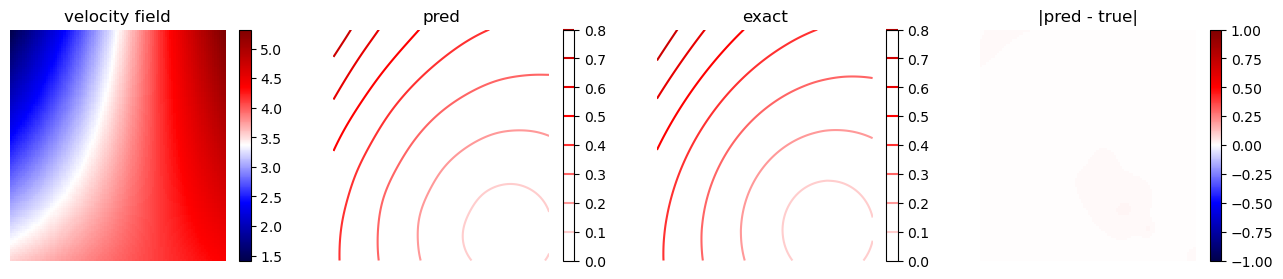

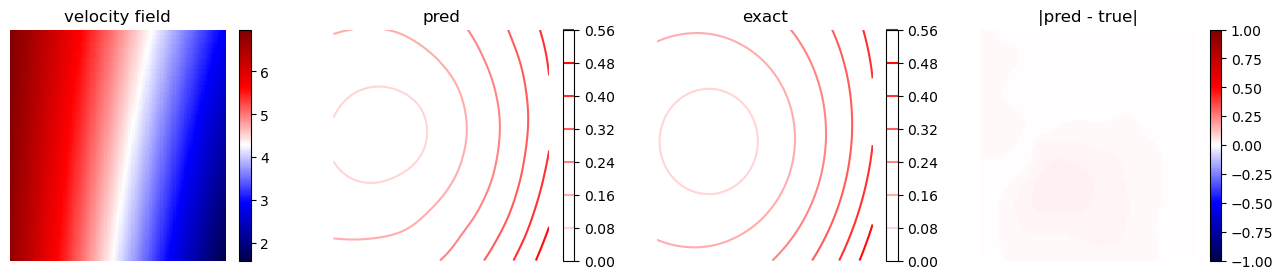

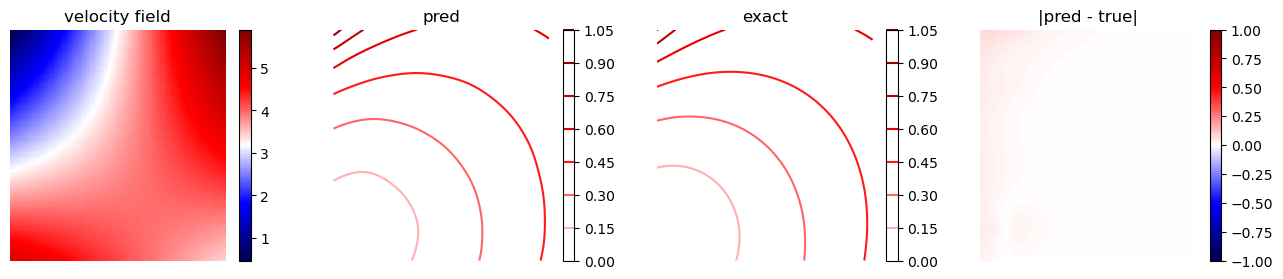

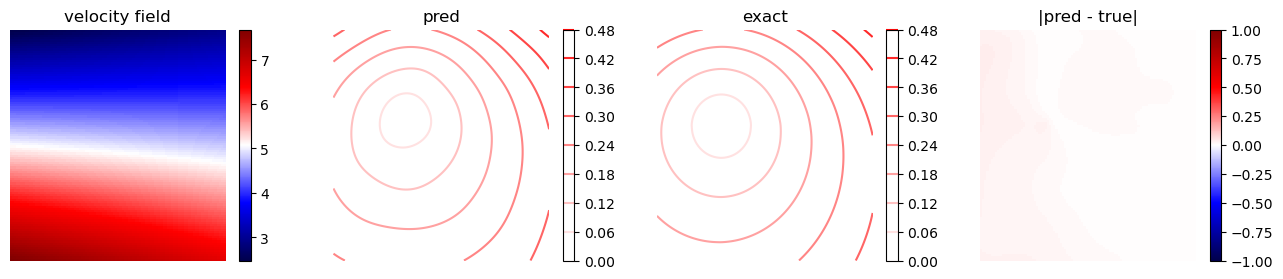

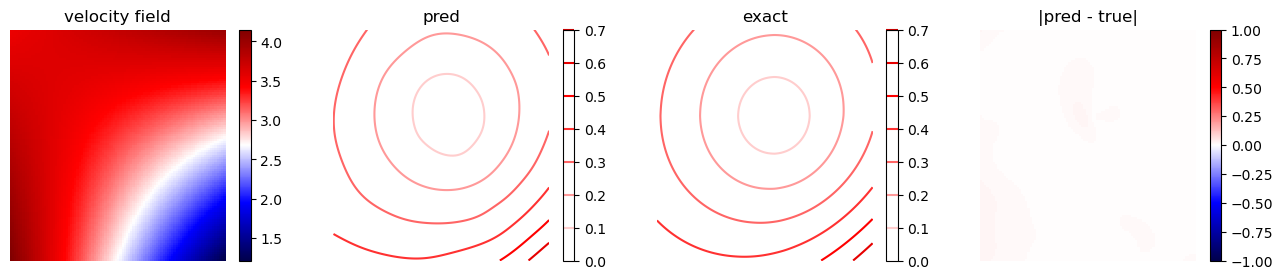

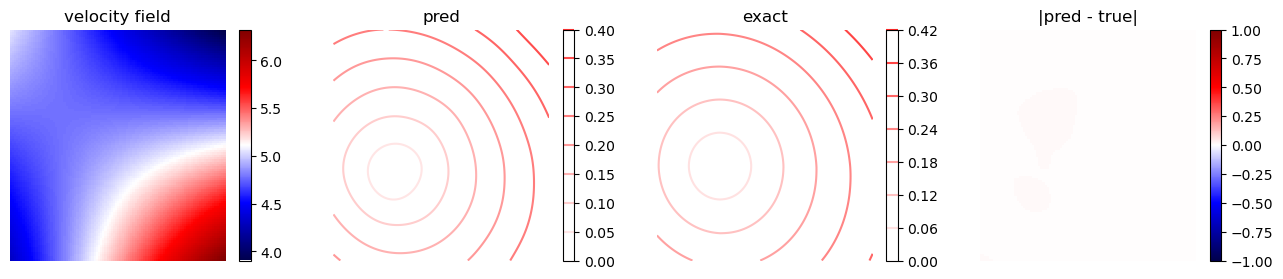

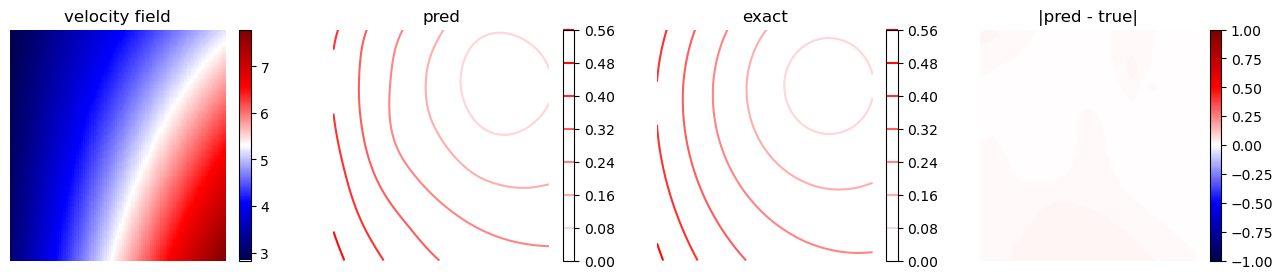

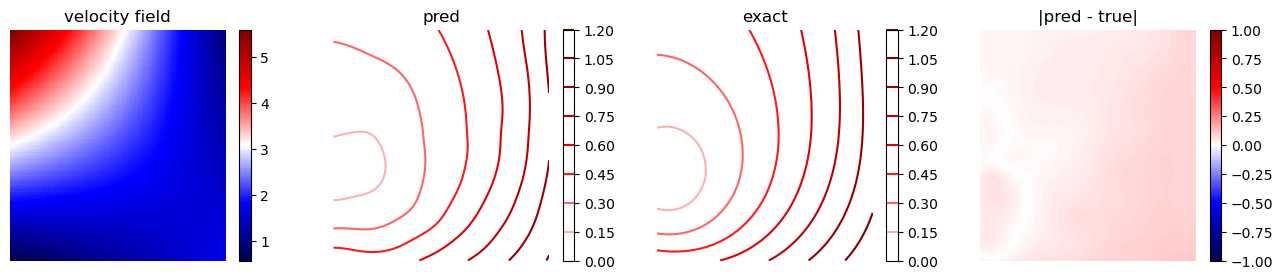

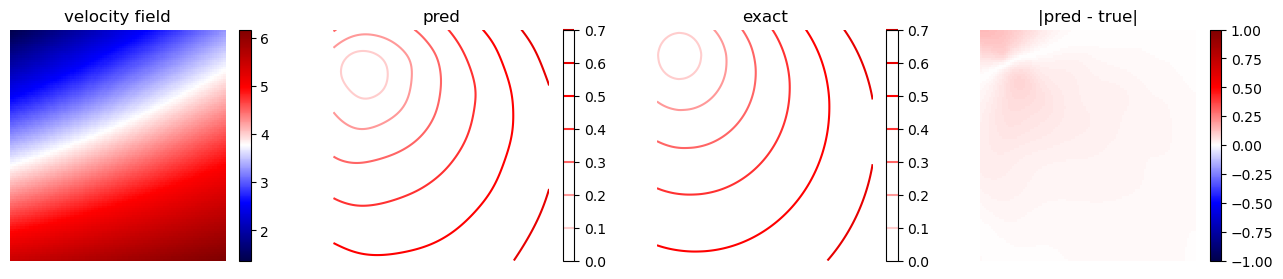

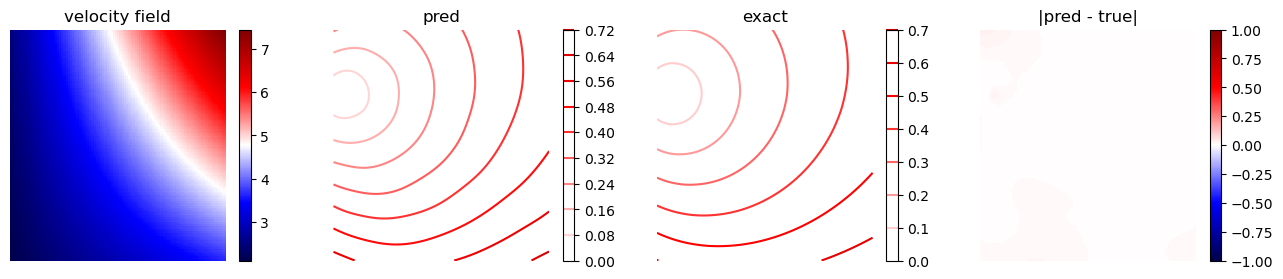

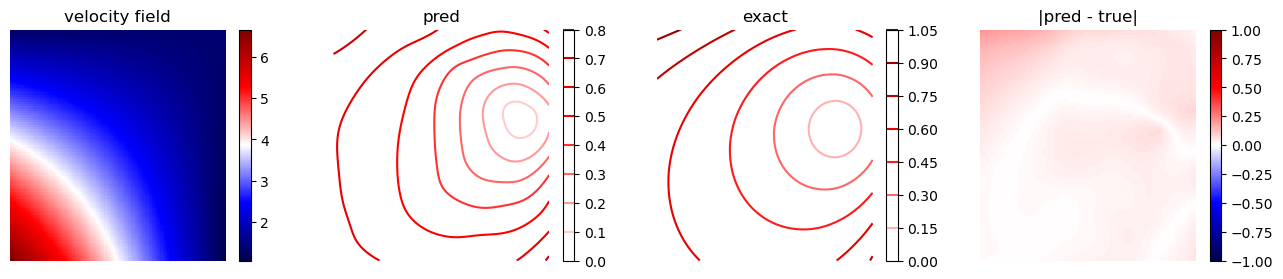

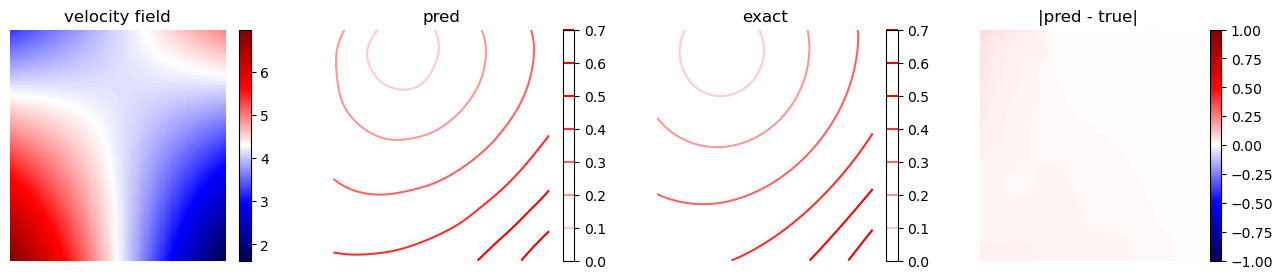

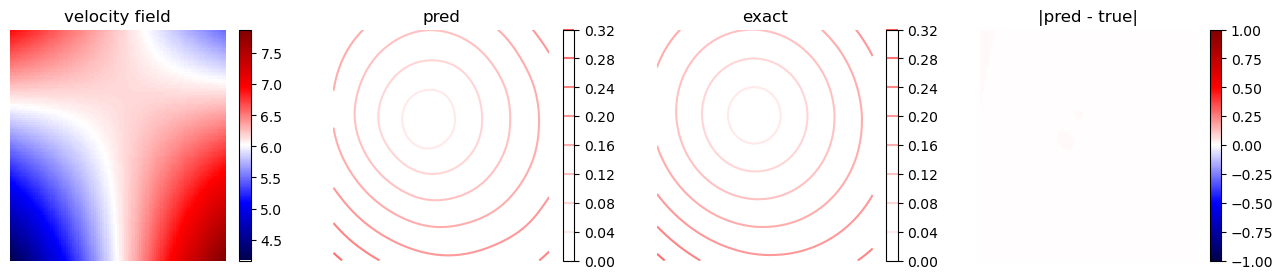

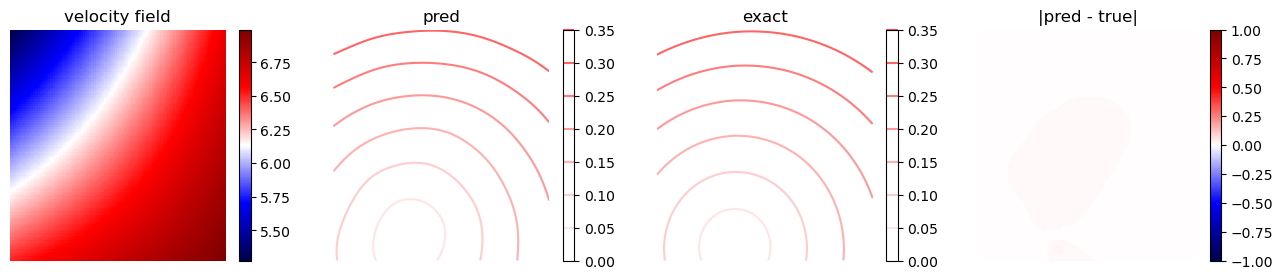

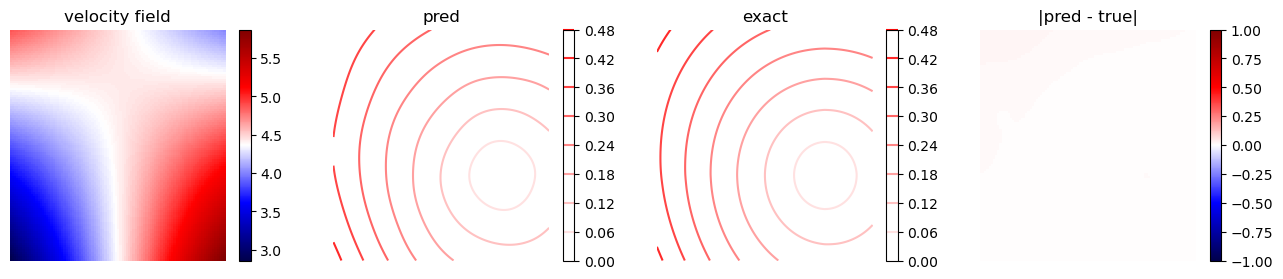

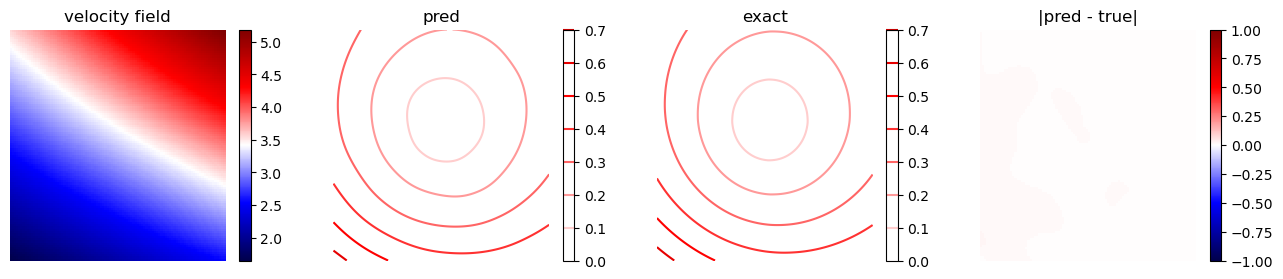

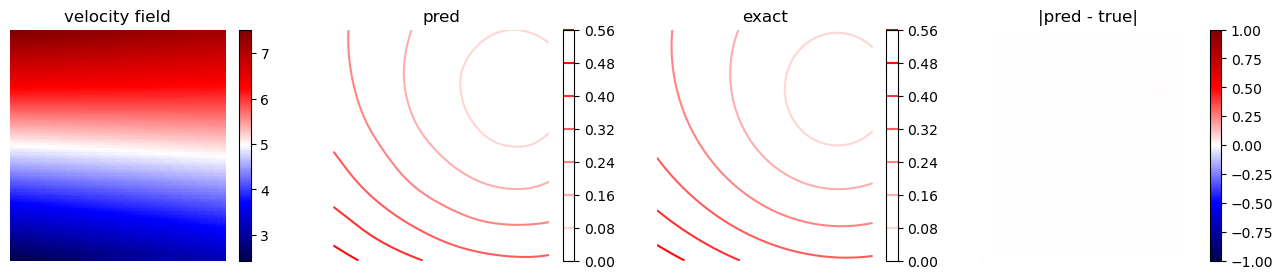

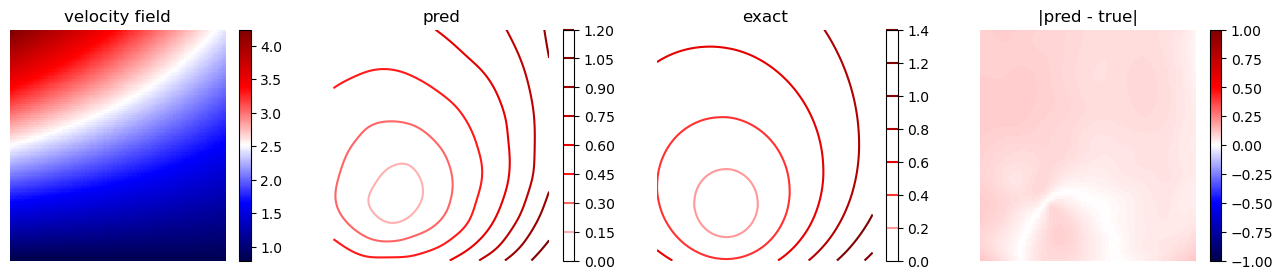

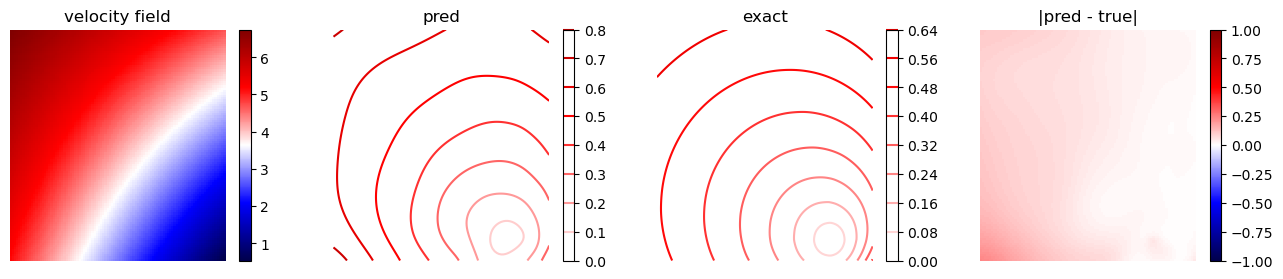

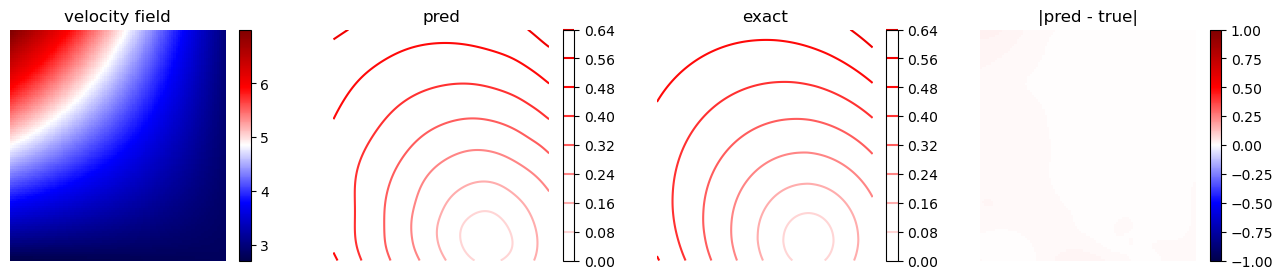

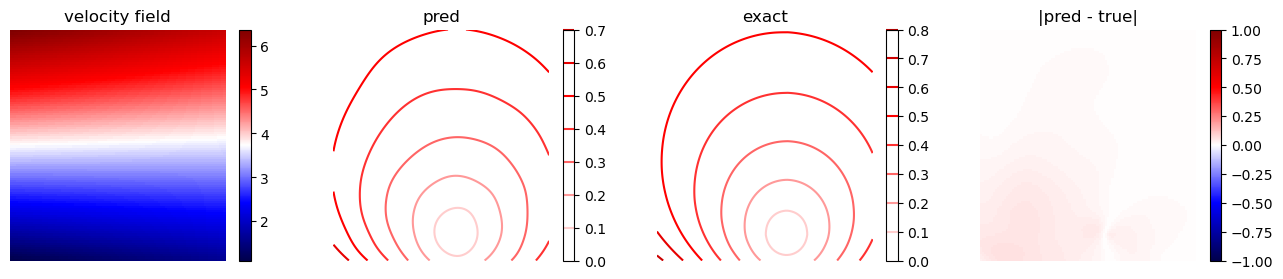

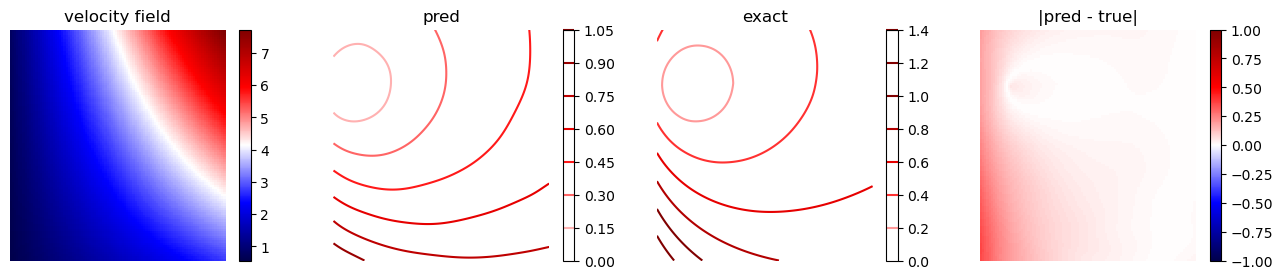

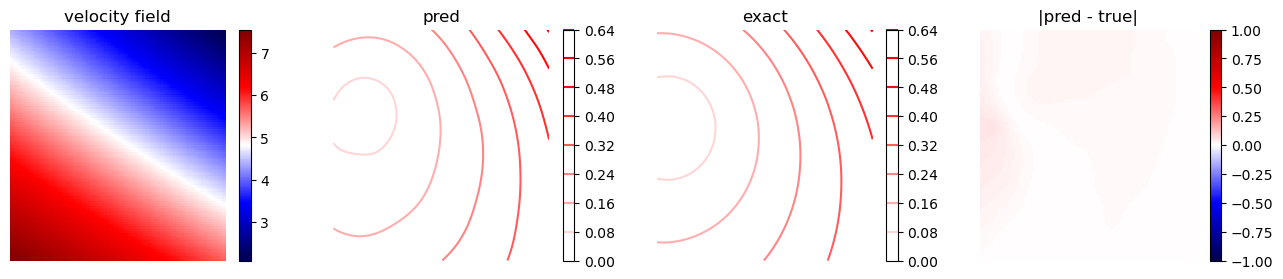

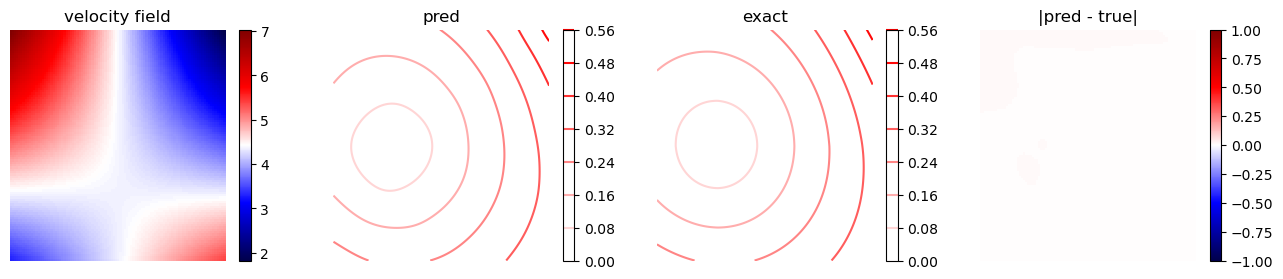

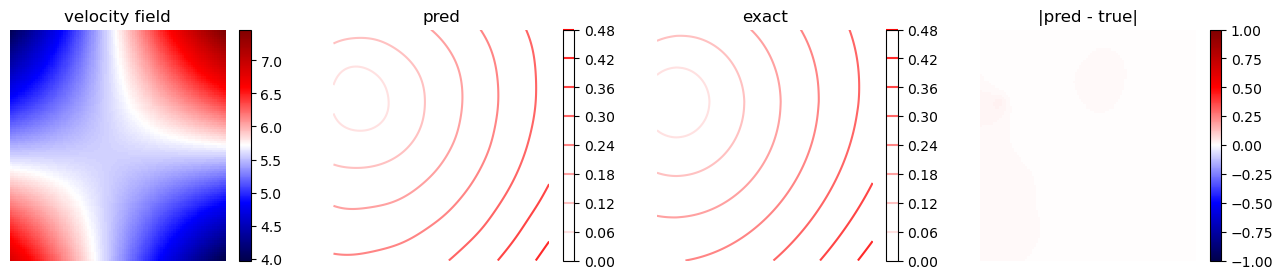

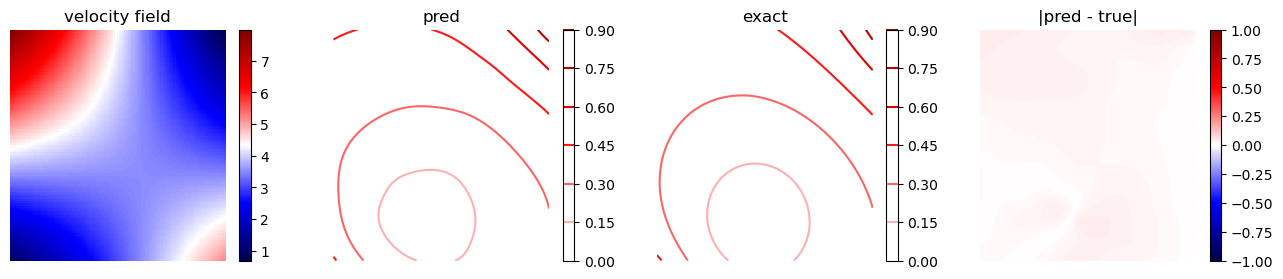

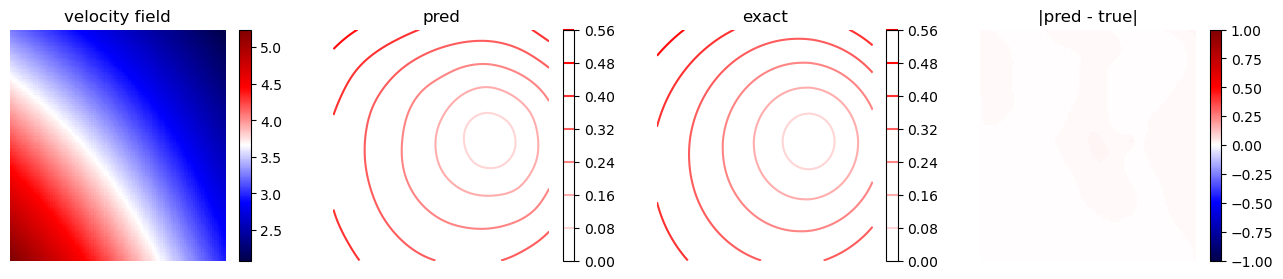

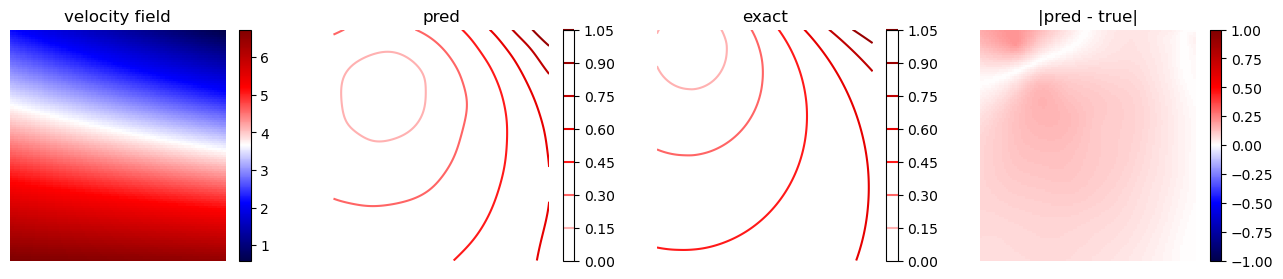

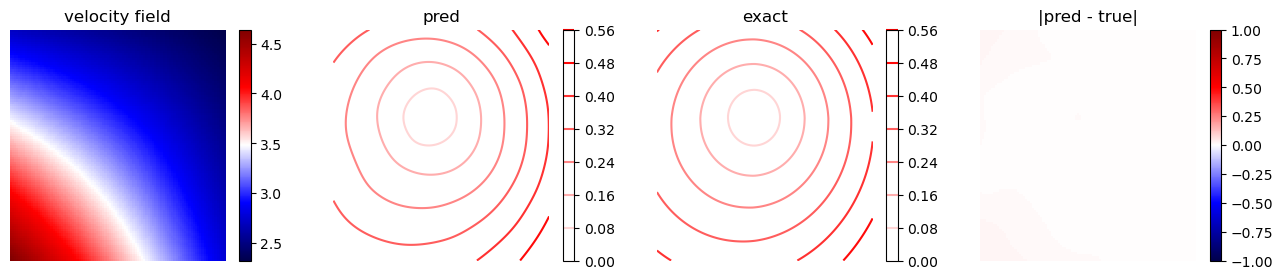

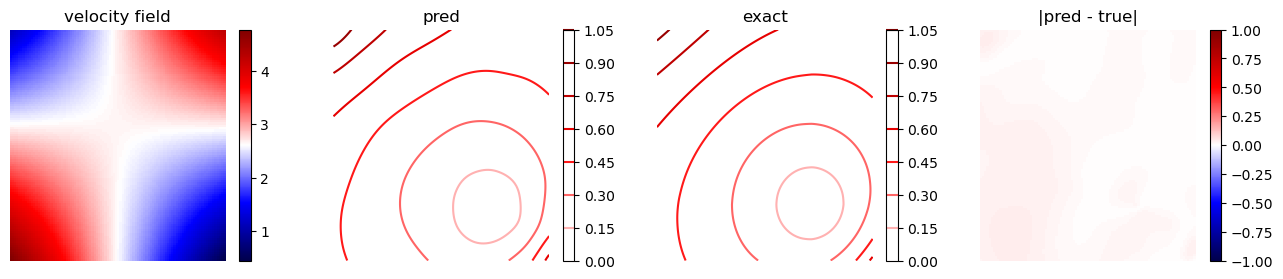

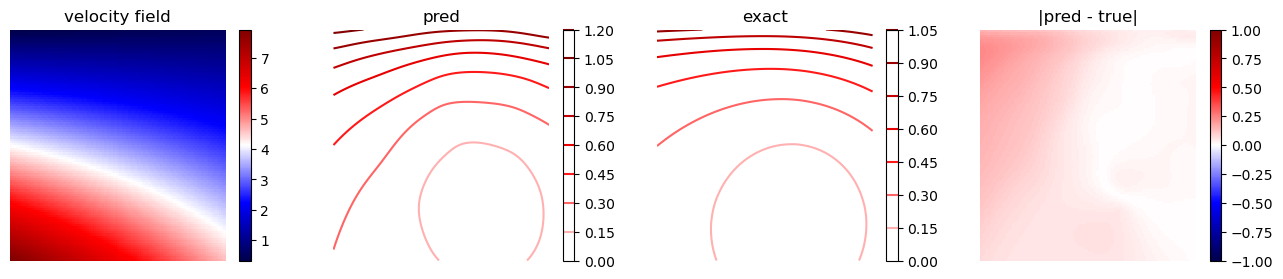

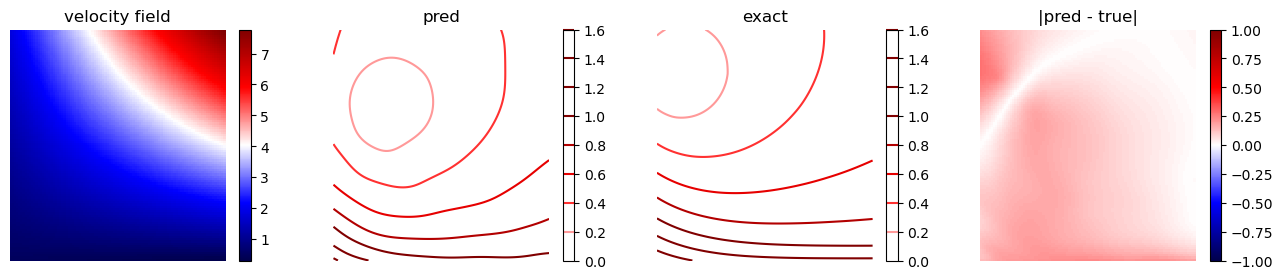

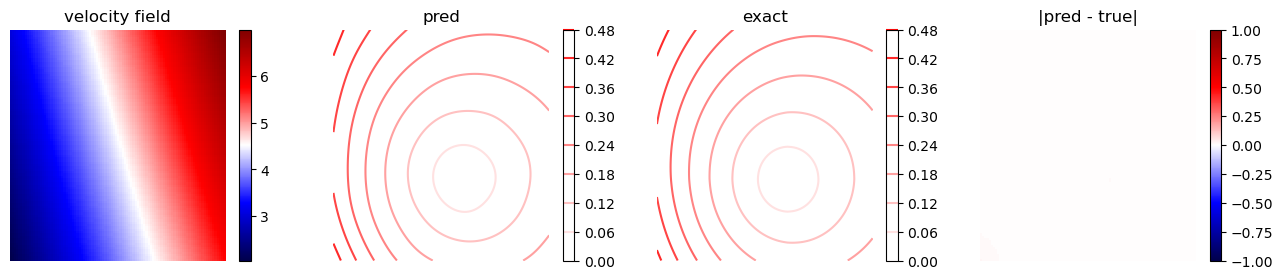

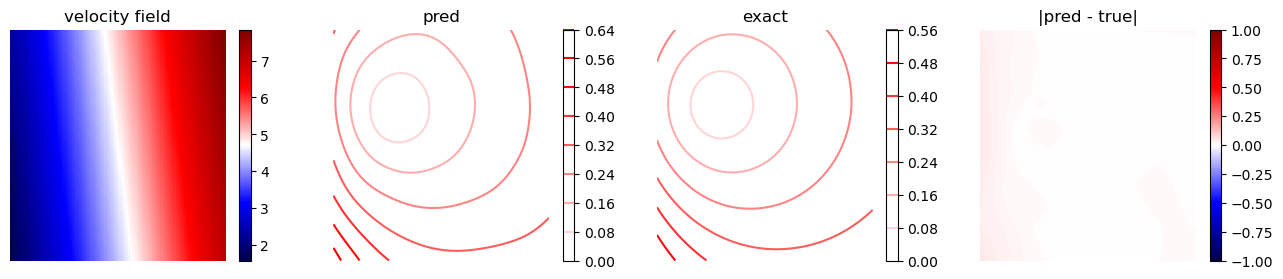

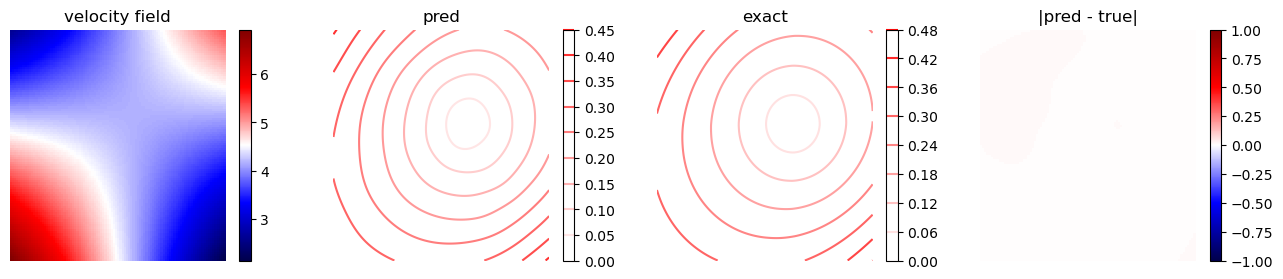

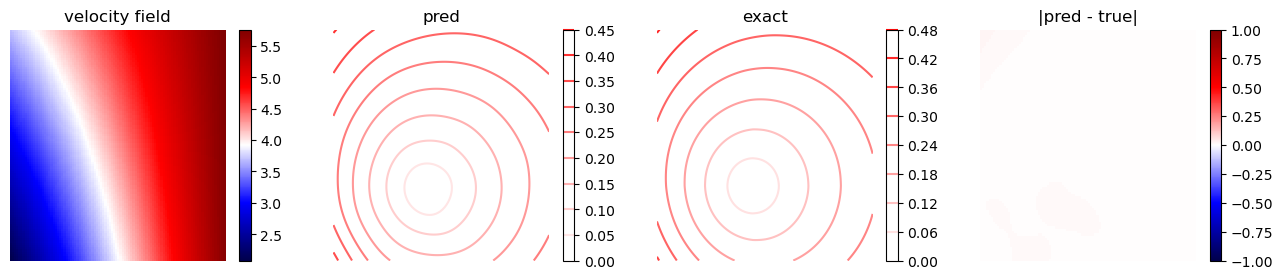

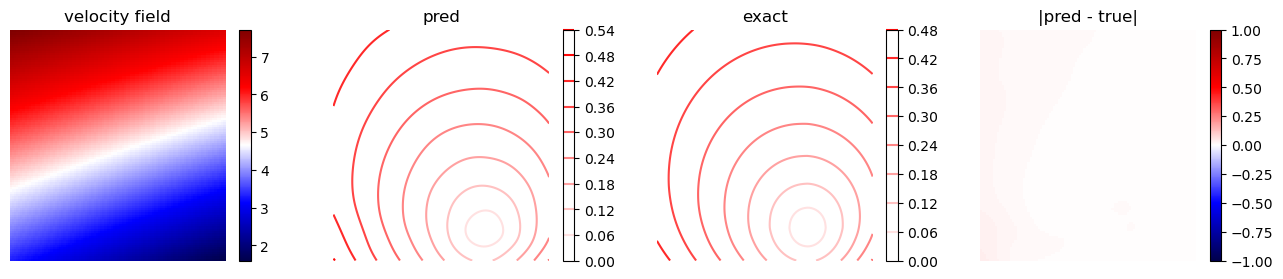

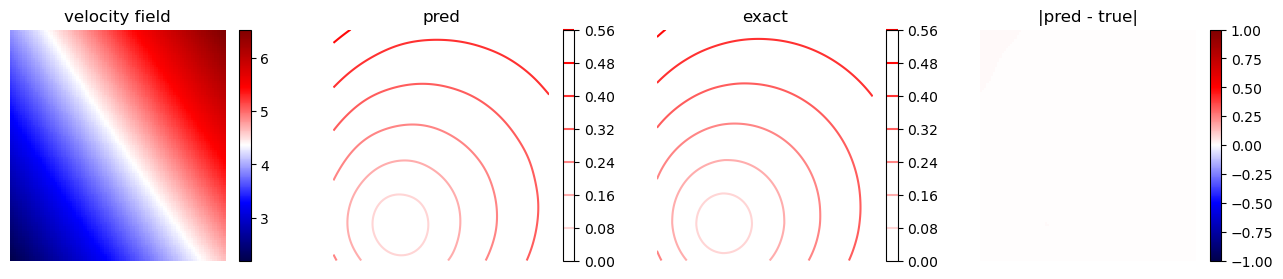

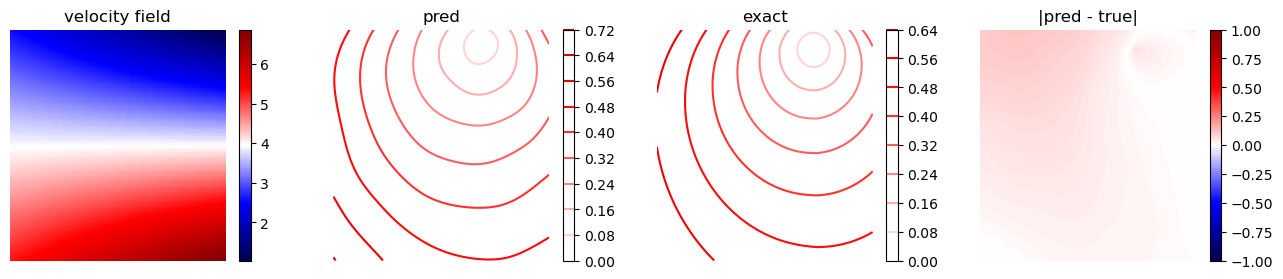

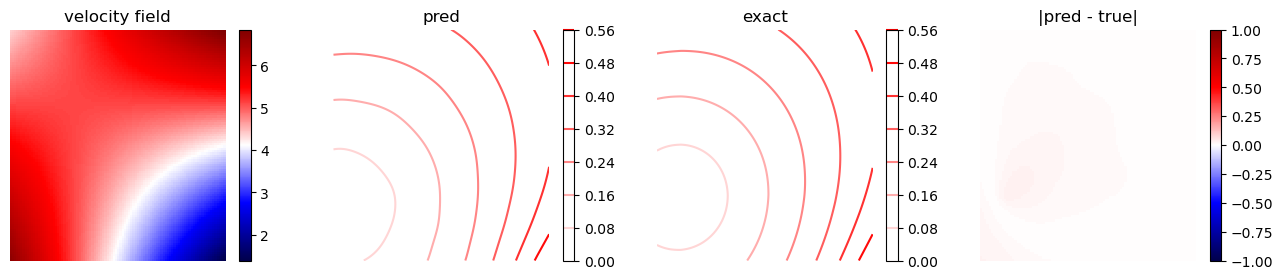

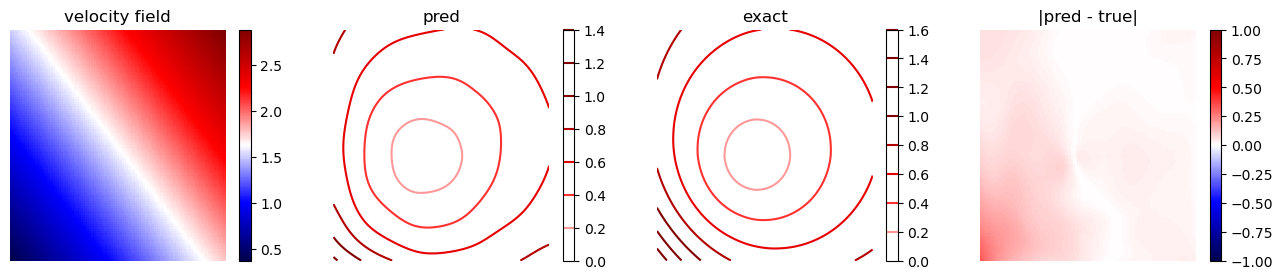

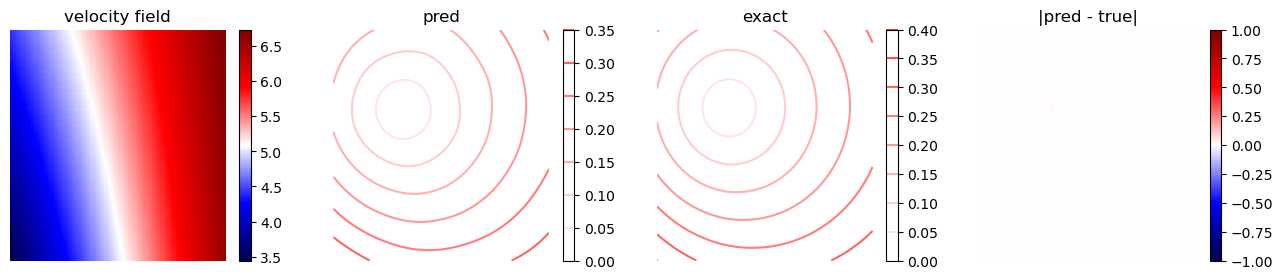

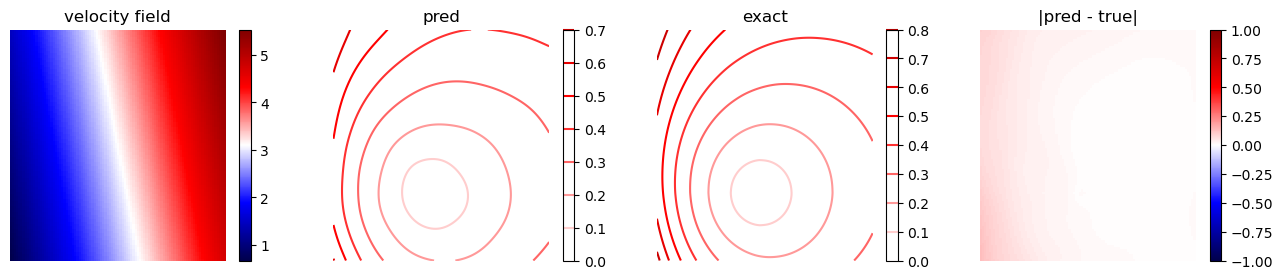

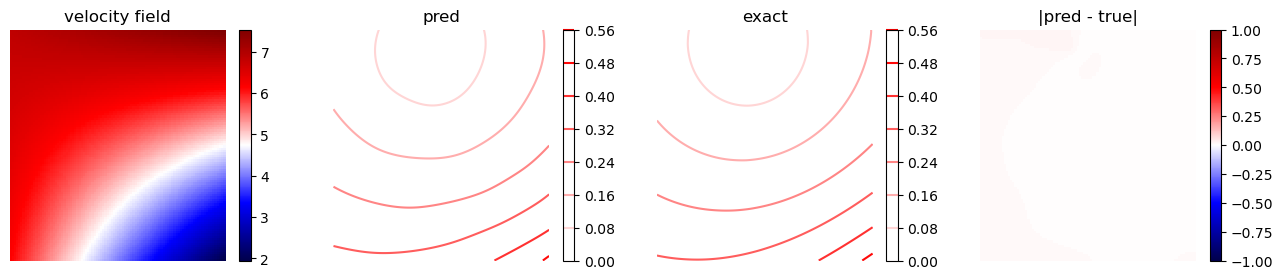

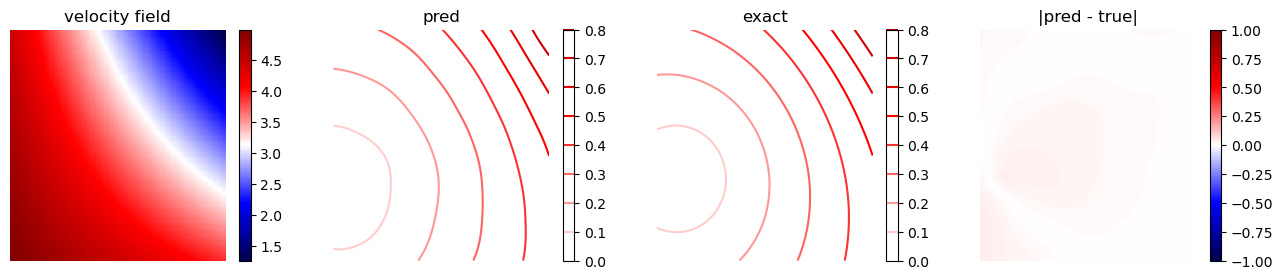

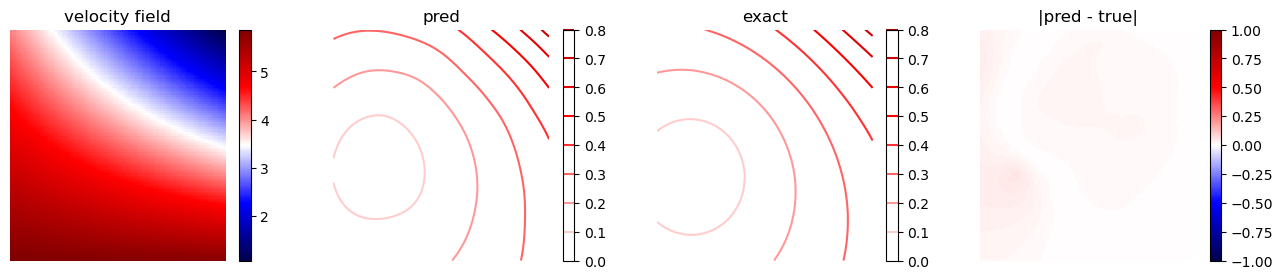

In [17]:
Nx, Ny = 100, 100

for i in range(50):
    v_corners = list(np.random.uniform(VMIN, VMAX, (4,)))
    x_source, y_source = list(np.random.uniform(-0.9, 0.9, (2,)))
    
    test_data, vel_data, target_data = dg.generate_test_data(x_source, y_source, v_corners, Nx=Nx, Ny=Ny, sensor_size=SENSOR_SIZE)

    x_test = test_data[0].reshape(Nx, Ny)
    y_test = test_data[1].reshape(Nx, Ny)
    v_test = vel_data.reshape(Nx, Ny)
    exact = target_data.reshape(Nx, Ny)
        
    pred = DON.eval_u(test_data).reshape(Nx, Ny)

    fig, ax = plt.subplots(1, 4, figsize=(16, 3))
    
    ax0 = ax[0].pcolor(x_test, y_test, v_test, cmap='seismic')
    ax[0].set_title('velocity field')
    ax[0].axis('off')
    plt.colorbar(ax0, ax=ax[0])
    
    ax1 = ax[1].contour(x_test, y_test, pred, cmap='seismic', vmin=-1, vmax=1)
    ax[1].set_title('pred')
    ax[1].axis('off')
    plt.colorbar(ax1, ax=ax[1])
    
    ax2 = ax[2].contour(x_test, y_test, exact, cmap='seismic', vmin=-1, vmax=1)
    ax[2].set_title('exact')
    ax[2].axis('off')
    plt.colorbar(ax2, ax=ax[2])
    
    ax3 = ax[3].pcolor(x_test, y_test, abs(pred - exact), cmap='seismic', vmin=-1, vmax=1)
    ax[3].set_title('|pred - true|')
    ax[3].axis('off')
    plt.colorbar(ax3, ax=ax[3])
    
    plt.show()

In [18]:
DON.train_lbfgs(dg, epochs=1000, verbose=0)

10000 - -9424.0402135849s - re-sampling with vmin=0.2, vmax=8.0
10100 - -9530.597419977188s - re-sampling with vmin=0.2, vmax=8.0
10200 - -9637.78811955452s - re-sampling with vmin=0.2, vmax=8.0
10300 - -9745.533066987991s - re-sampling with vmin=0.2, vmax=8.0

Epoch 263: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
10400 - -9852.795846700668s - re-sampling with vmin=0.2, vmax=8.0

Epoch 363: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
10500 - -9960.327176570892s - re-sampling with vmin=0.2, vmax=8.0

Epoch 503: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
10600 - -10069.003824234009s - re-sampling with vmin=0.2, vmax=8.0
10700 - -10176.595124721527s - re-sampling with vmin=0.2, vmax=8.0

Epoch 603: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
10800 - -10284.159566640854s - re-sampling with vmin=0.2, vmax=8.0

Epoch 722: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
10900 - -103

In [19]:
DON.history_bfgs = DON.model_bfgs.train(
    dg,
    epochs=1000,
    batch_size=dg.batch_size,
    verbose=1,
    learning_rate=0.0001
)

200/200 [==============================] - 1s 4ms/step
itr: 0 loss: 1.1340e-04
200/200 [==============================] - 1s 5ms/step
itr: 0 loss: 2.1651e+02
200/200 [==============================] - 1s 5ms/step
itr: 0 loss: 2.7822e+01
200/200 [==============================] - 1s 5ms/step
itr: 0 loss: 3.2096e+00
200/200 [==============================] - 1s 5ms/step
itr: 0 loss: 3.6676e-01
200/200 [==============================] - 1s 5ms/step
itr: 0 loss: 4.3766e-02
200/200 [==============================] - 1s 5ms/step
itr: 0 loss: 5.9275e-03
200/200 [==============================] - 1s 5ms/step
itr: 0 loss: 1.0657e-03
200/200 [==============================] - 1s 5ms/step
itr: 0 loss: 3.1230e-04
200/200 [==============================] - 1s 5ms/step
itr: 0 loss: 1.6351e-04
200/200 [==============================] - 1s 5ms/step
itr: 0 loss: 1.2751e-04
200/200 [==============================] - 1s 5ms/step
itr: 0 loss: 1.1759e-04
200/200 [==============================] - 1s 5ms/st

In [20]:
DON.model.save_weights('EnDeepONet_SmoothVelocity/weights-lbfgs.hdf5')

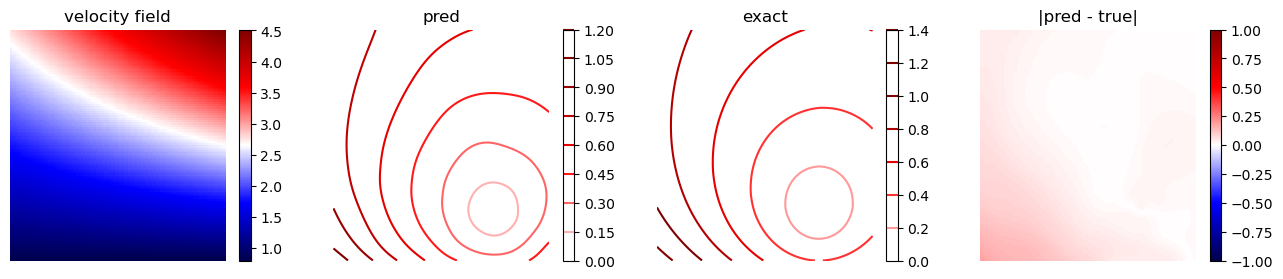

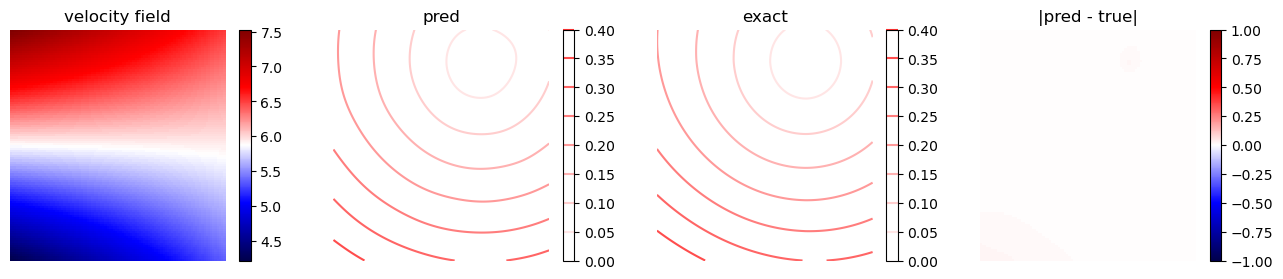

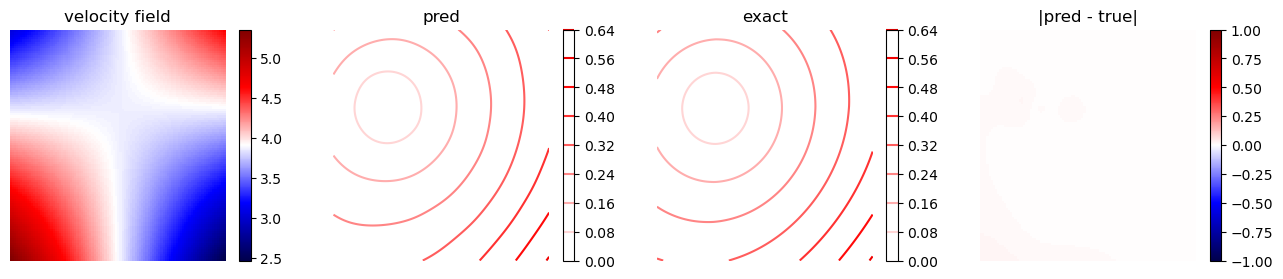

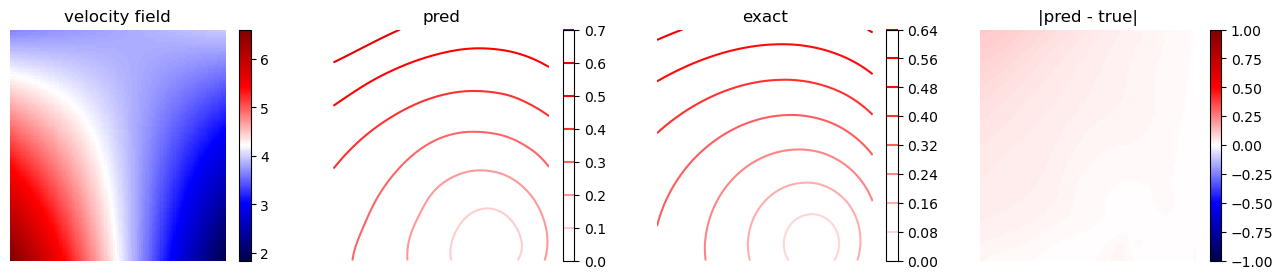

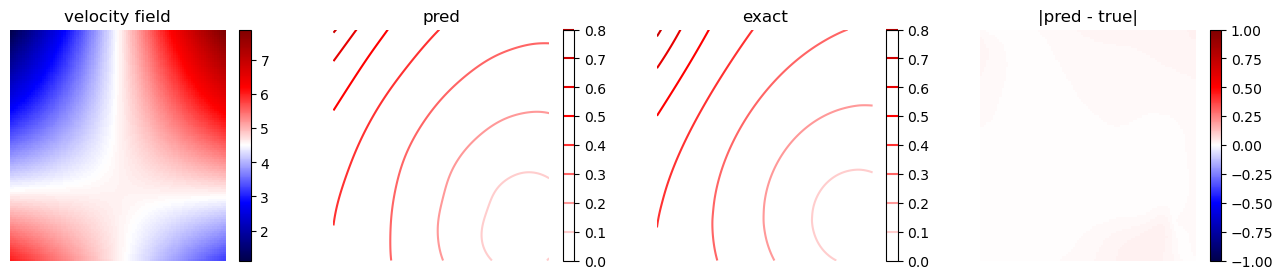

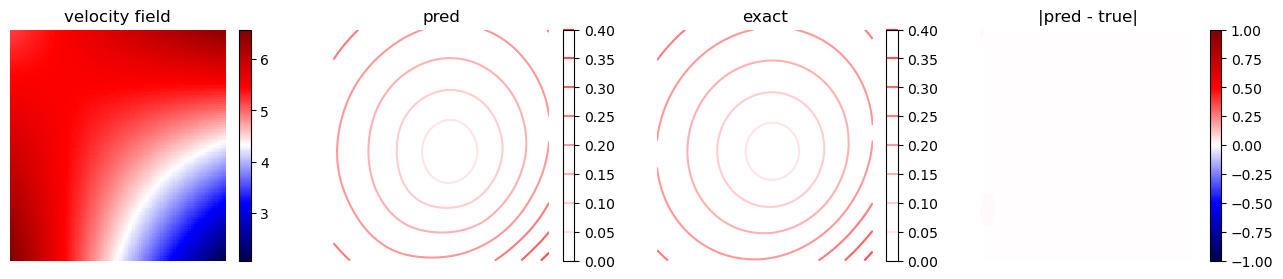

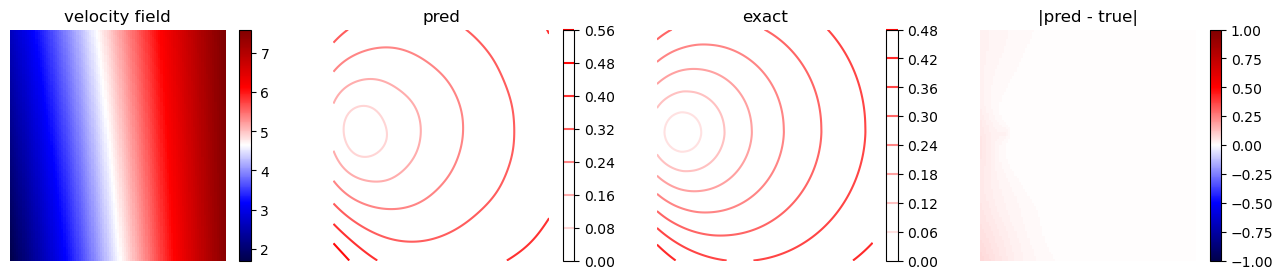

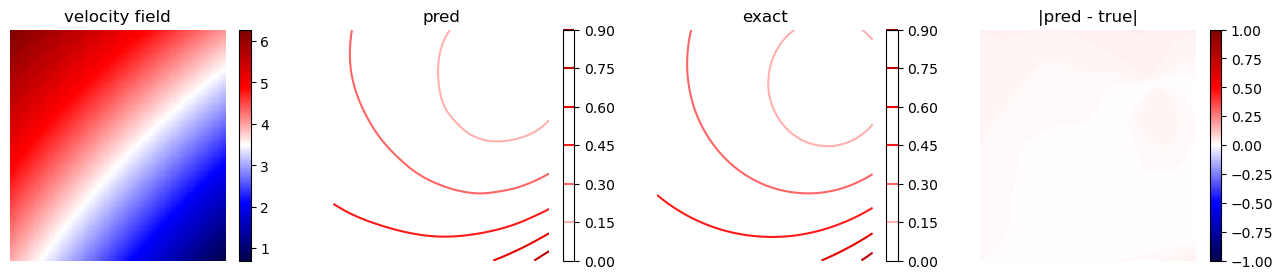

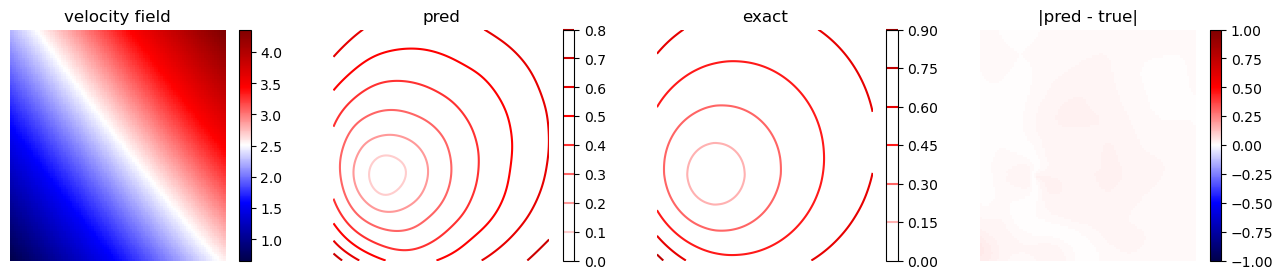

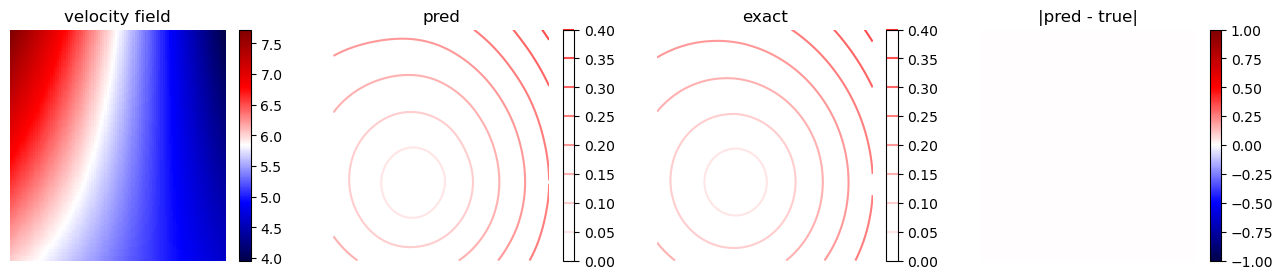

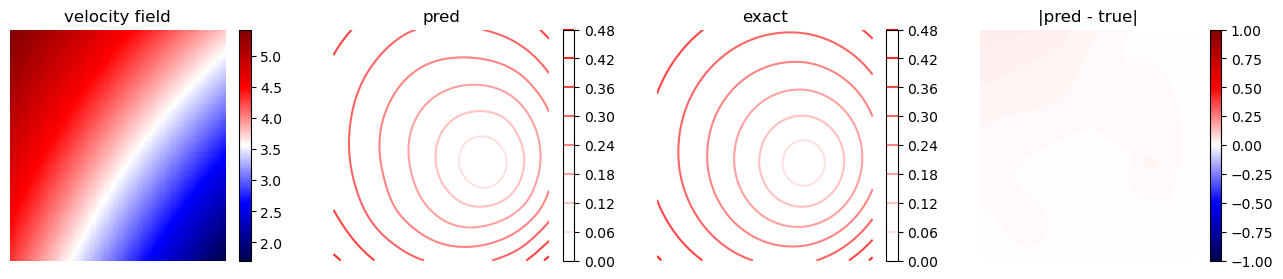

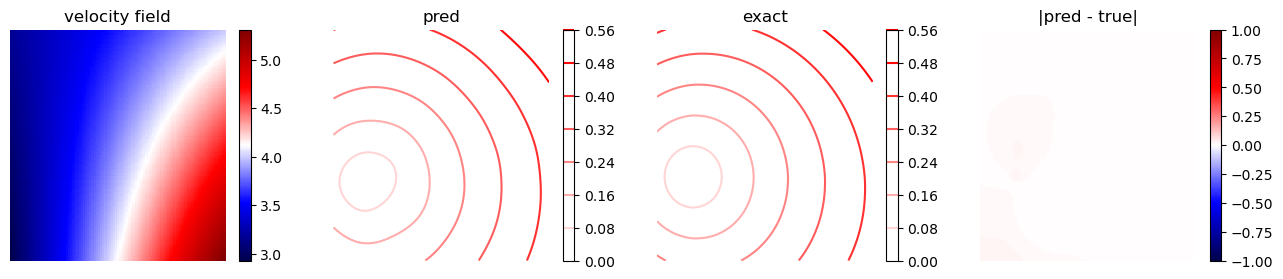

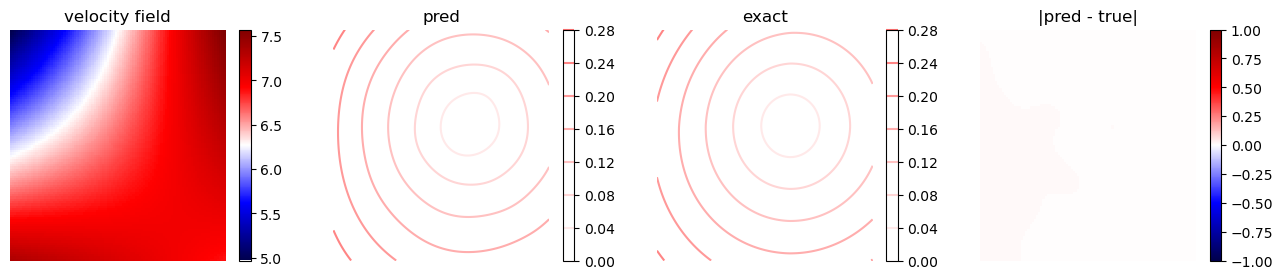

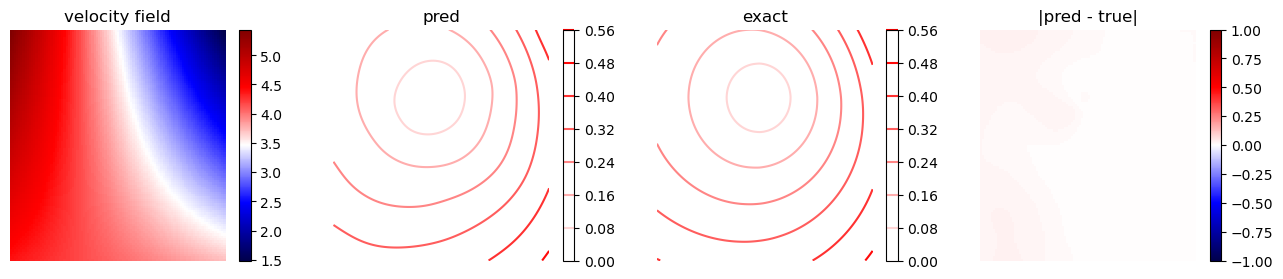

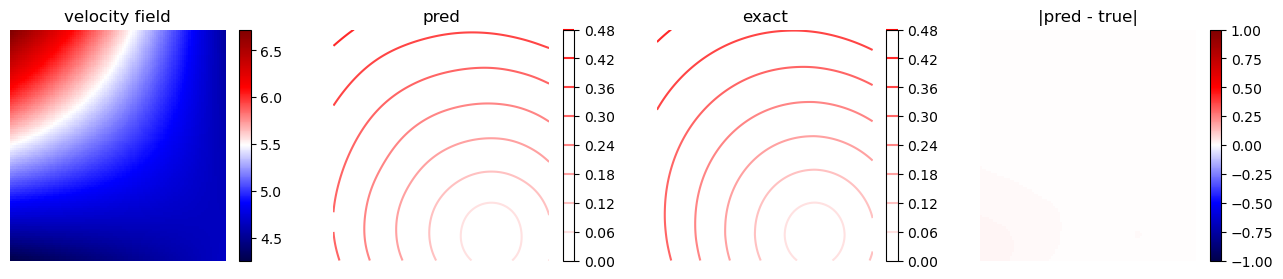

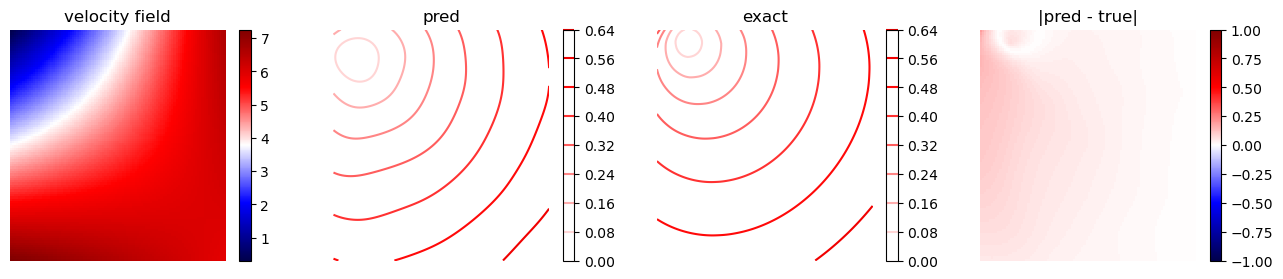

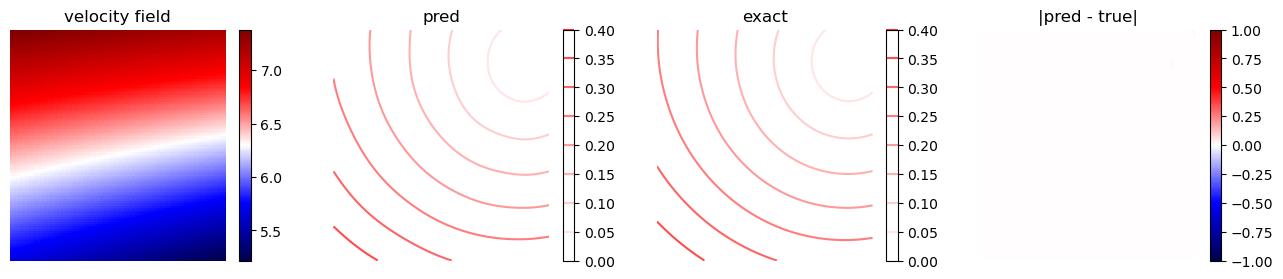

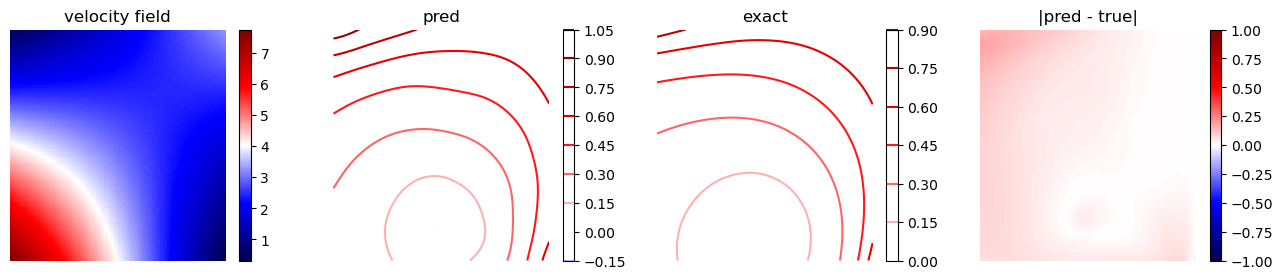

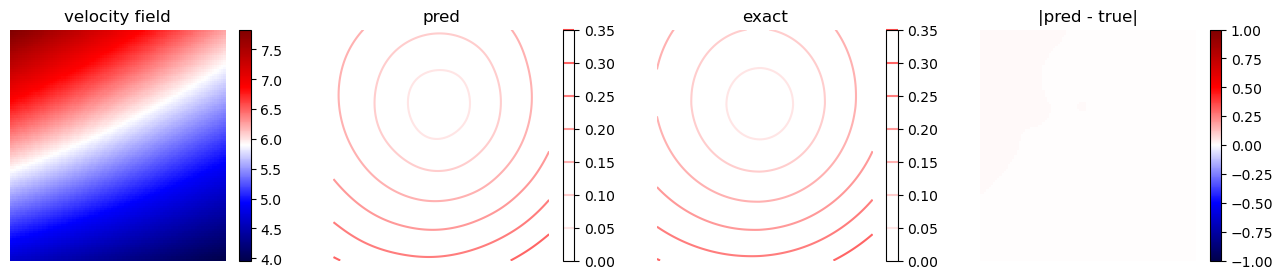

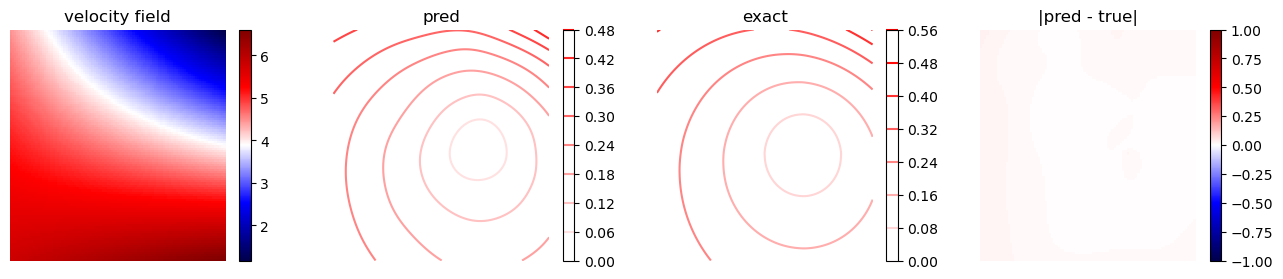

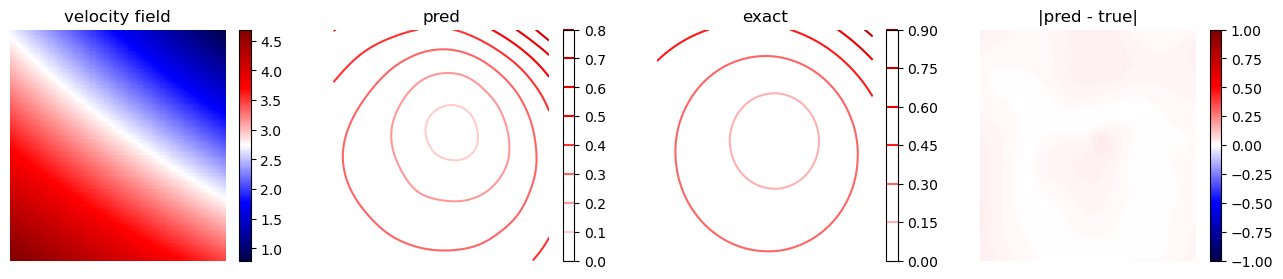

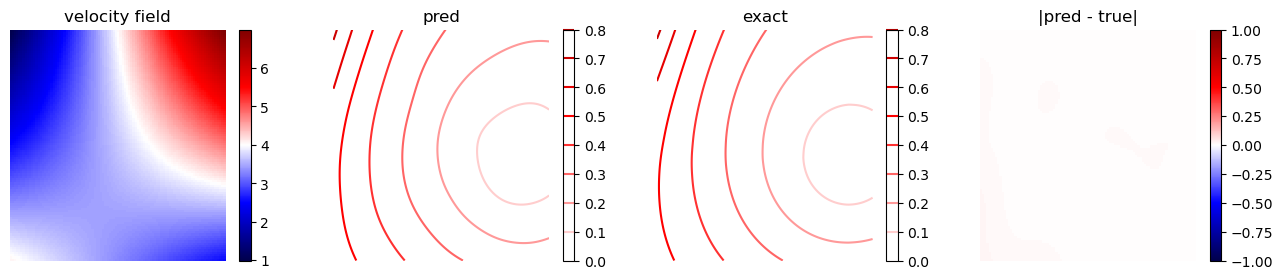

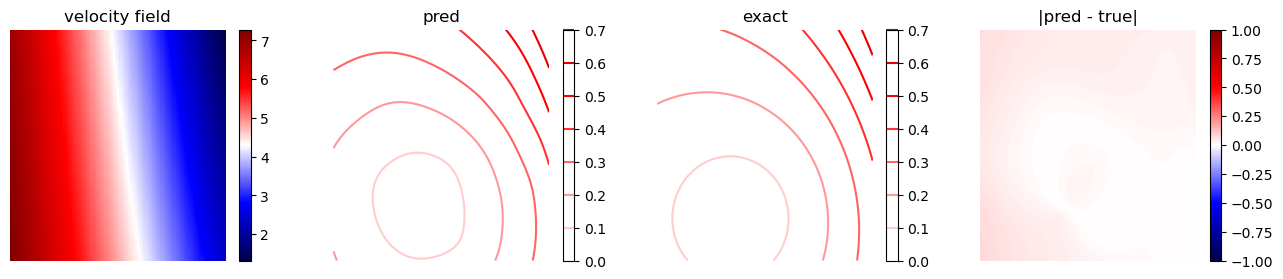

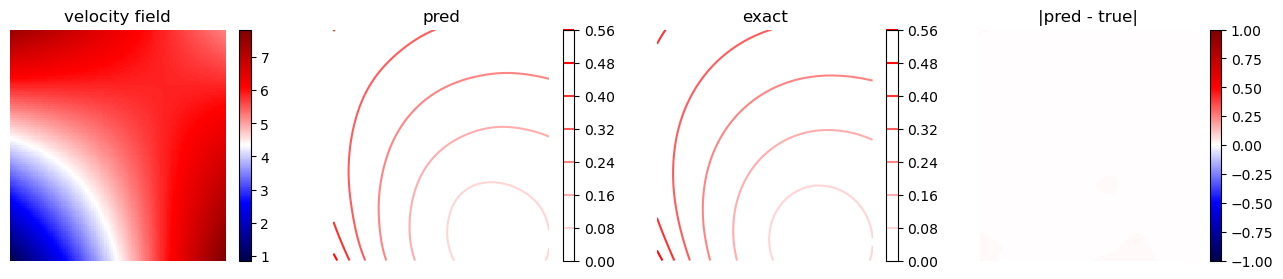

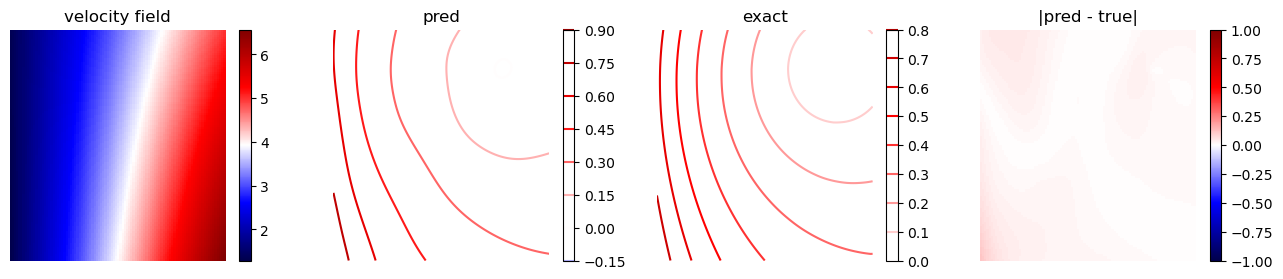

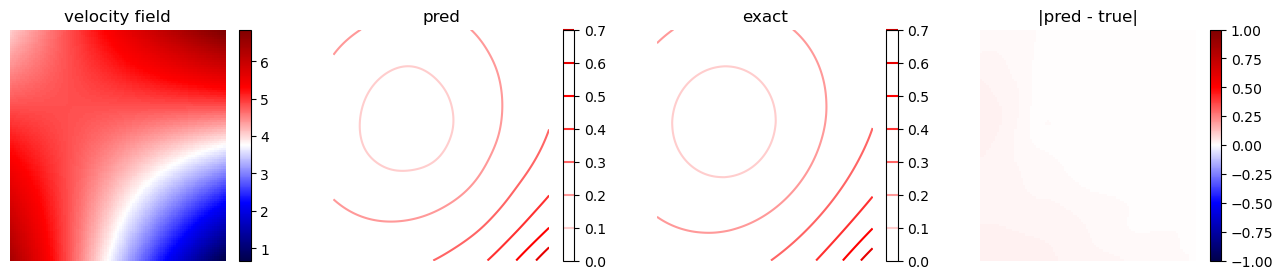

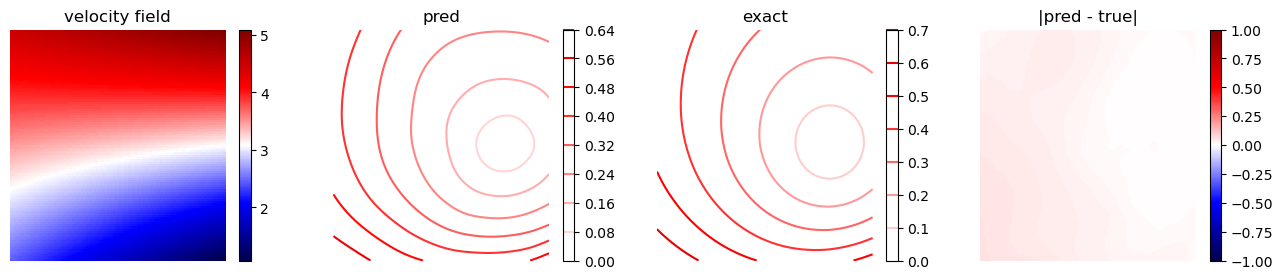

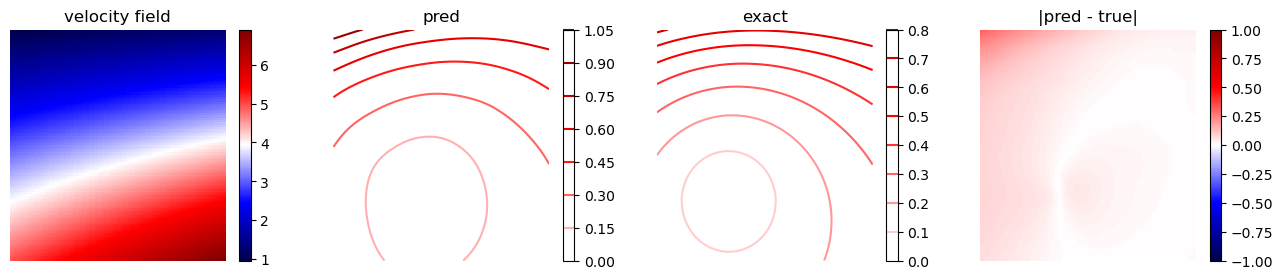

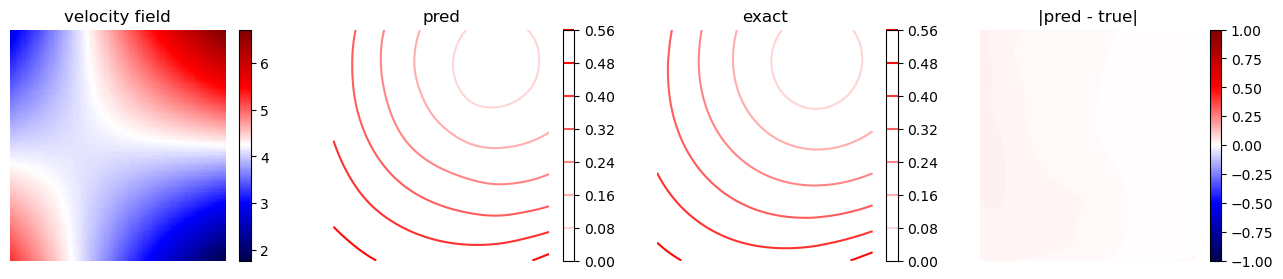

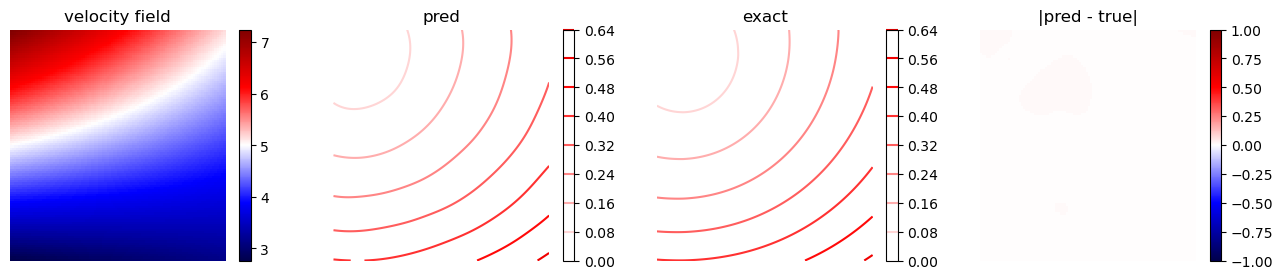

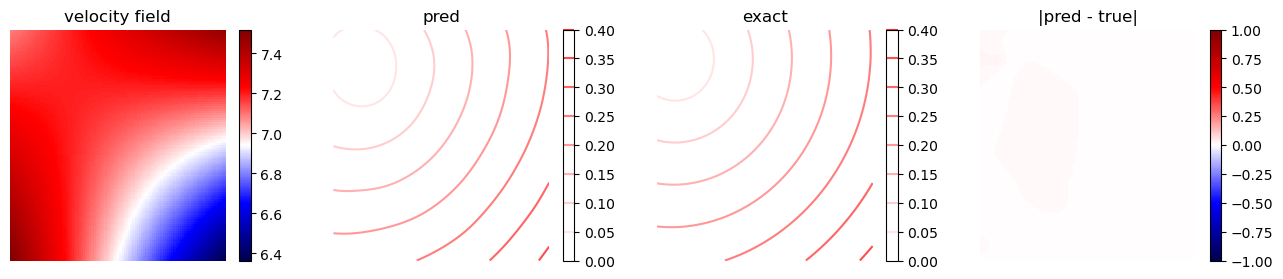

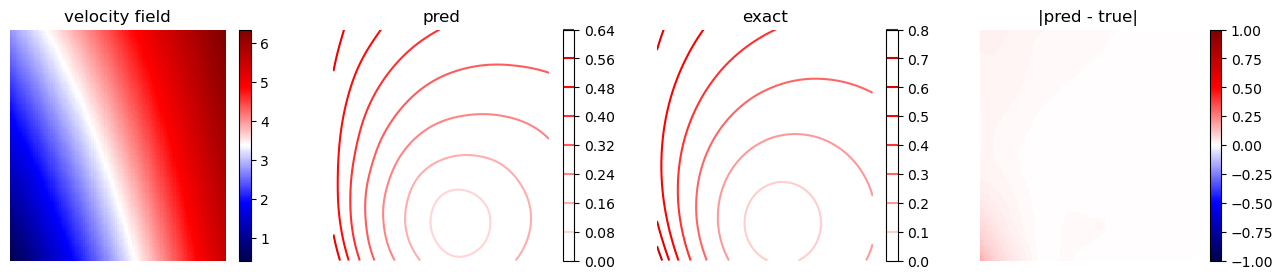

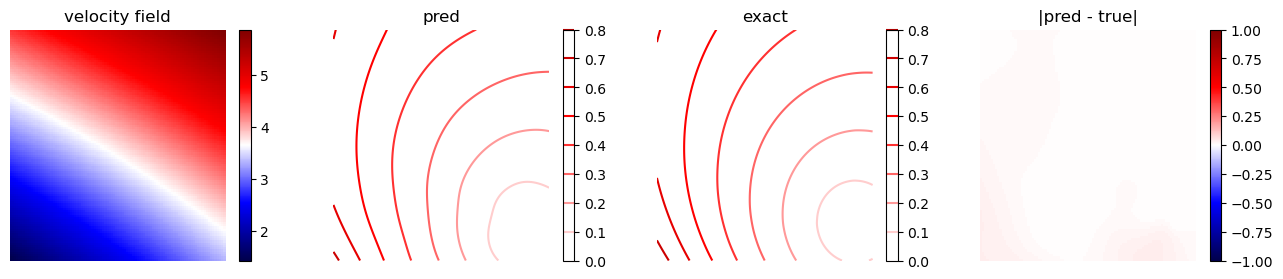

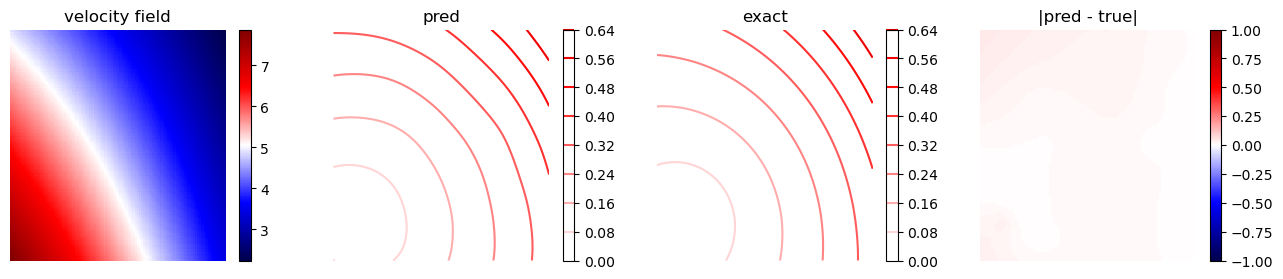

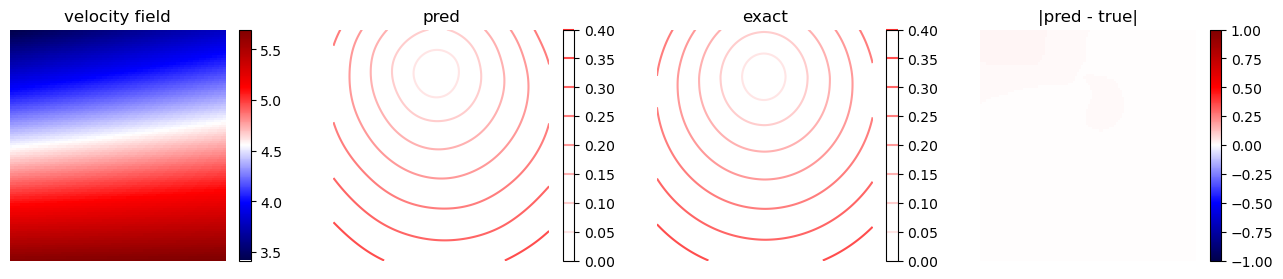

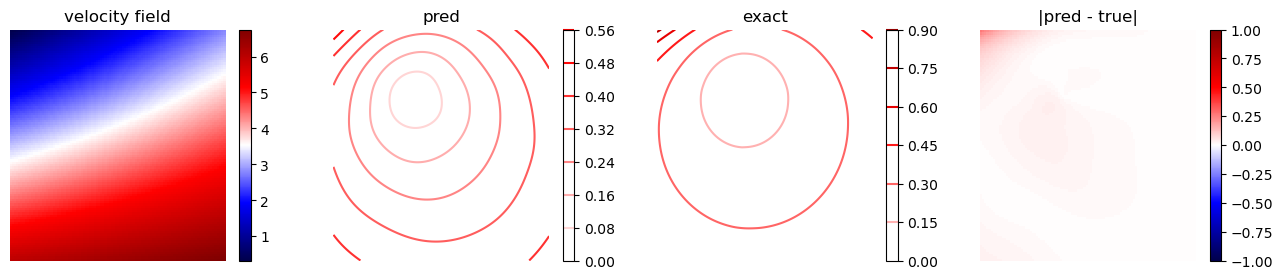

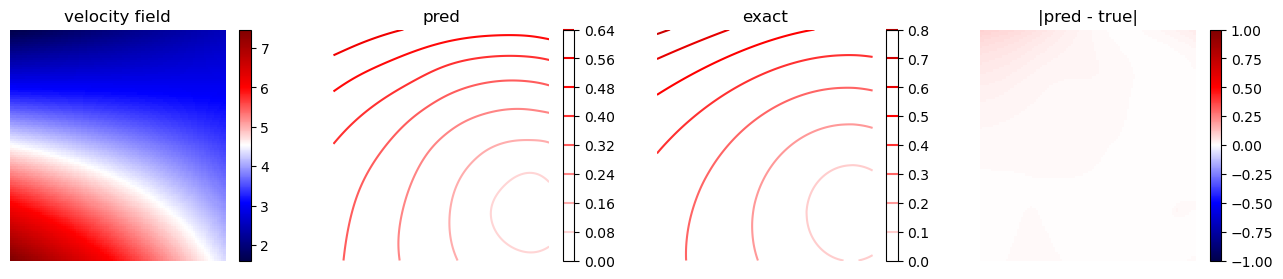

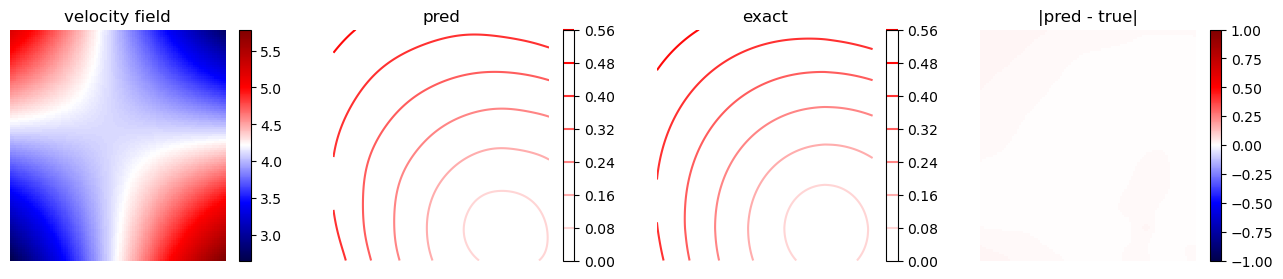

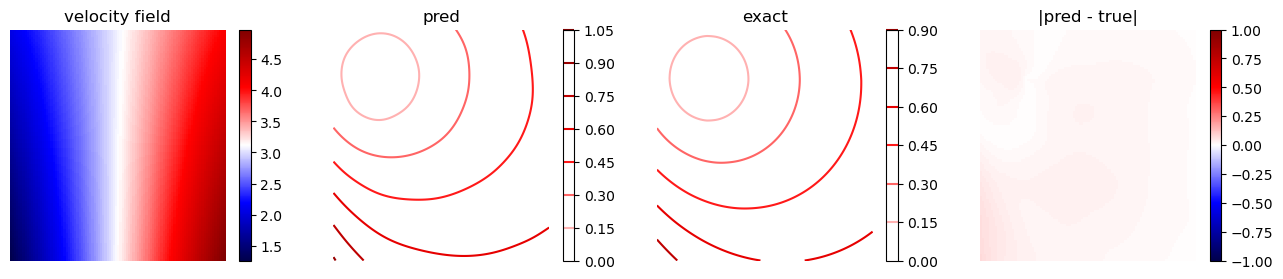

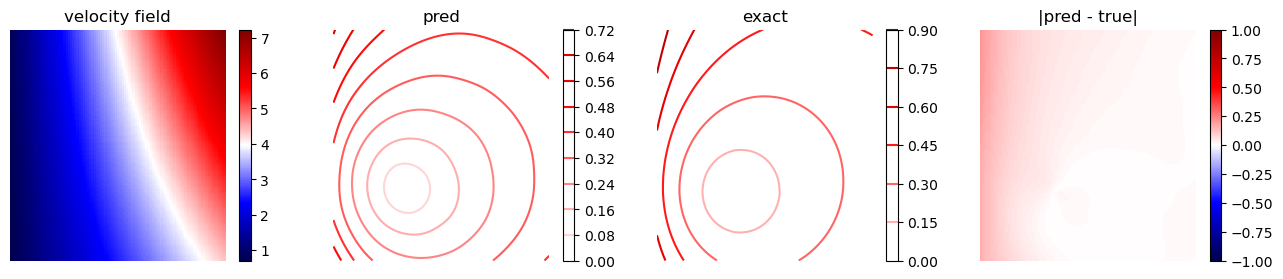

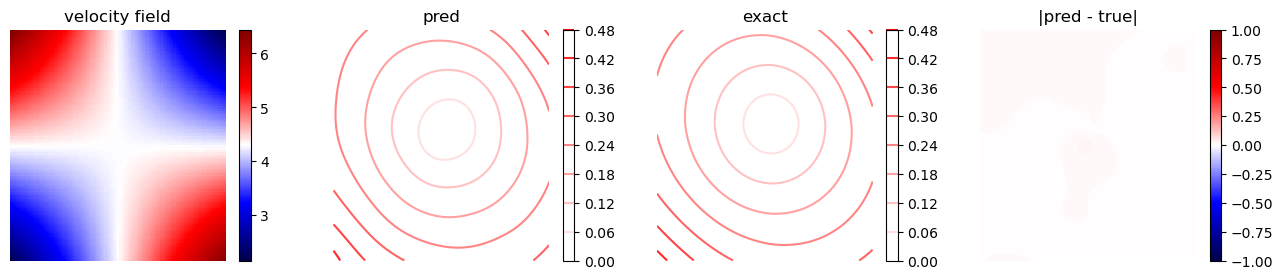

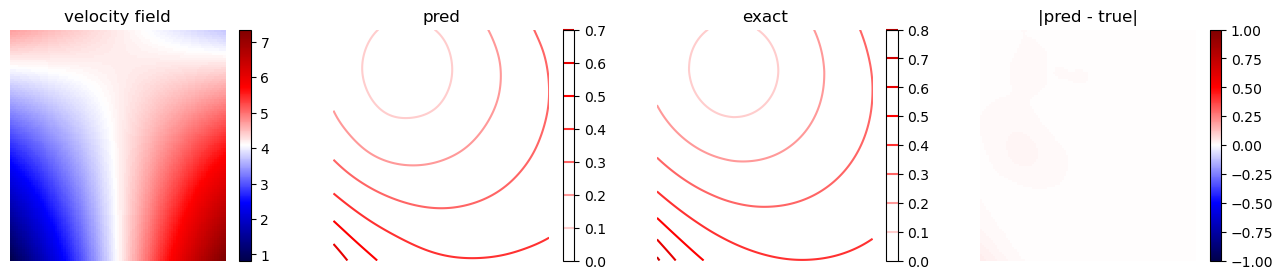

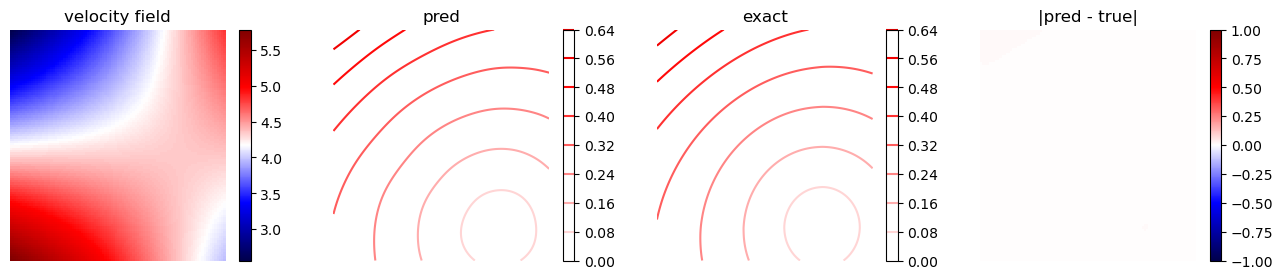

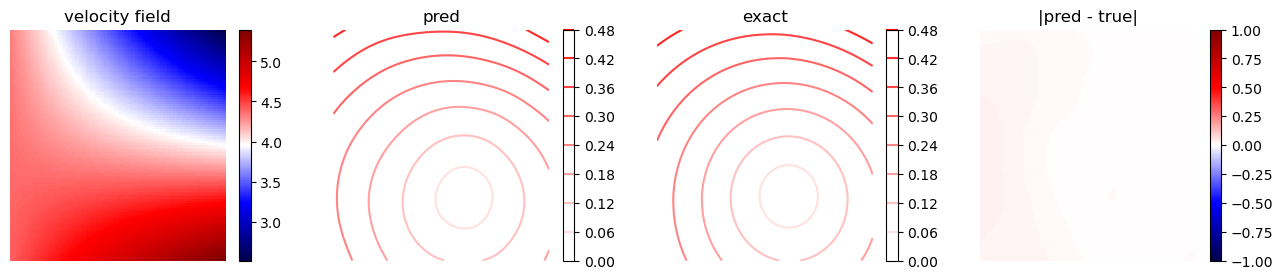

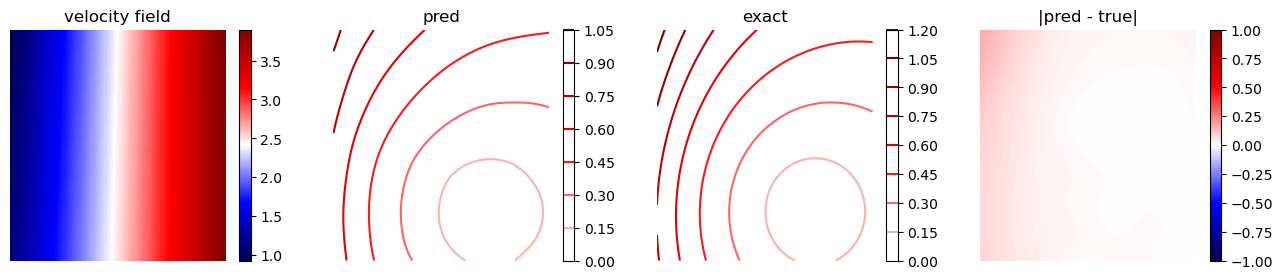

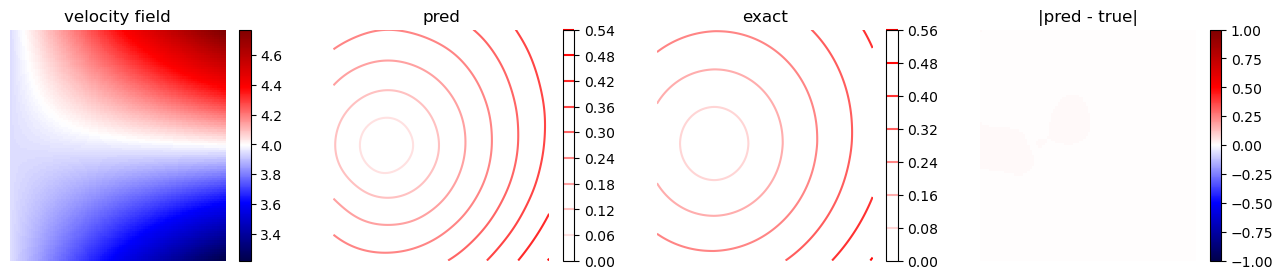

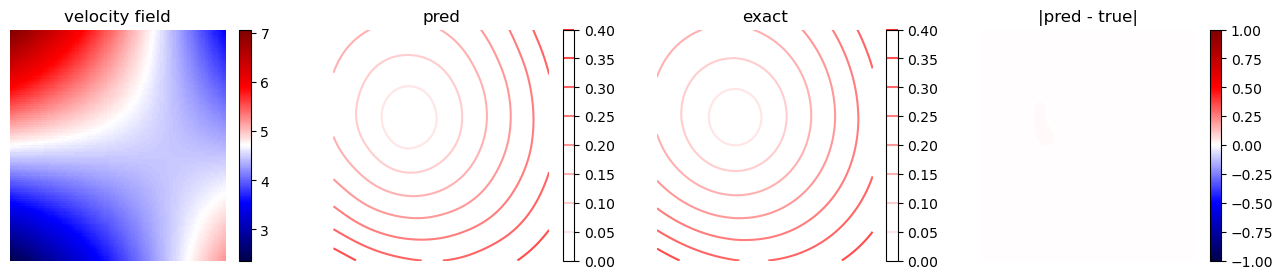

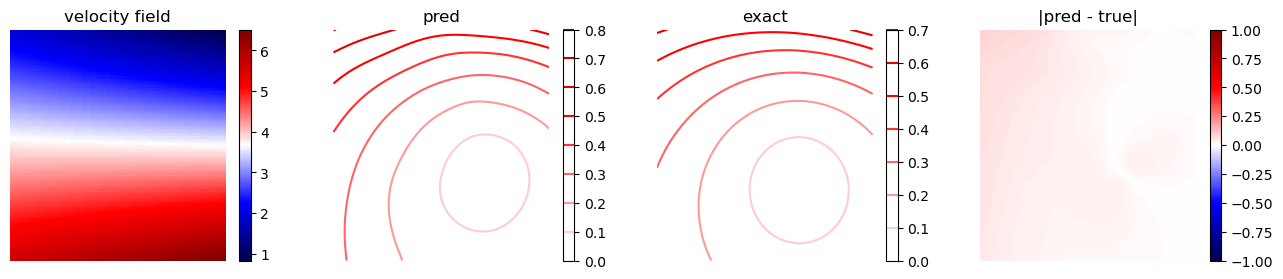

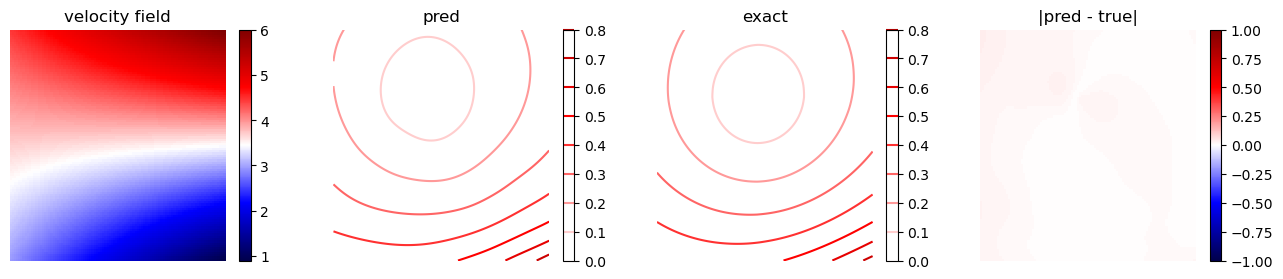

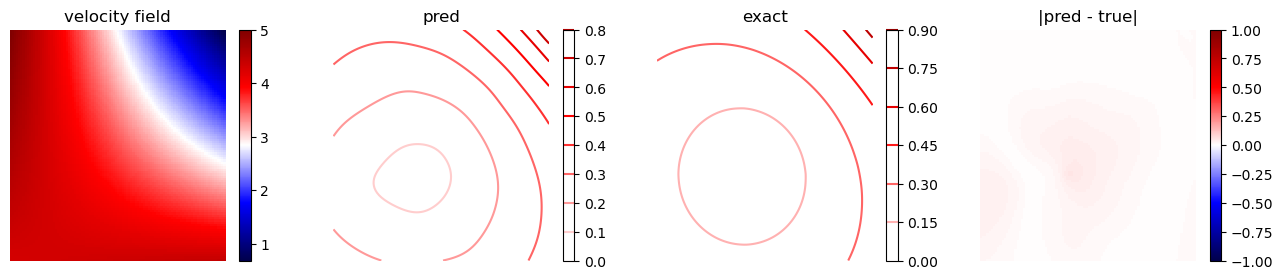

In [21]:
Nx, Ny = 100, 100

for i in range(50):
    v_corners = list(np.random.uniform(VMIN, VMAX, (4,)))
    x_source, y_source = list(np.random.uniform(-0.9, 0.9, (2,)))
    
    test_data, vel_data, target_data = dg.generate_test_data(x_source, y_source, v_corners, Nx=Nx, Ny=Ny, sensor_size=SENSOR_SIZE)

    x_test = test_data[0].reshape(Nx, Ny)
    y_test = test_data[1].reshape(Nx, Ny)
    v_test = vel_data.reshape(Nx, Ny)
    exact = target_data.reshape(Nx, Ny)
        
    pred = DON.eval_u(test_data).reshape(Nx, Ny)

    fig, ax = plt.subplots(1, 4, figsize=(16, 3))
    
    ax0 = ax[0].pcolor(x_test, y_test, v_test, cmap='seismic')
    ax[0].set_title('velocity field')
    ax[0].axis('off')
    plt.colorbar(ax0, ax=ax[0])
    
    ax1 = ax[1].contour(x_test, y_test, pred, cmap='seismic', vmin=-1, vmax=1)
    ax[1].set_title('pred')
    ax[1].axis('off')
    plt.colorbar(ax1, ax=ax[1])
    
    ax2 = ax[2].contour(x_test, y_test, exact, cmap='seismic', vmin=-1, vmax=1)
    ax[2].set_title('exact')
    ax[2].axis('off')
    plt.colorbar(ax2, ax=ax[2])
    
    ax3 = ax[3].pcolor(x_test, y_test, abs(pred - exact), cmap='seismic', vmin=-1, vmax=1)
    ax[3].set_title('|pred - true|')
    ax[3].axis('off')
    plt.colorbar(ax3, ax=ax[3])
    
    plt.show()